In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from tqdm import tqdm
from tsnecuda import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

/tmp/ipykernel_2599472/3445827236.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# parameters
dataset_name = ""
model_name = "resnet_ce_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "0:2:3"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 42153 images
Dataset type val label type: species


Loaded 5269 images
Dataset type test label type: species


Loaded 5270 images
Dataset type test label type: species


Loaded 43520 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:2:3 1y6ktp79


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-1y6ktp79:best, 58.48MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.2


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []
    trn_rcn_fpi = []
    trn_emb_fpi = []
    trn_lgt_fpi = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []
    val_rcn_fpi = []
    val_emb_fpi = []
    val_lgt_fpi = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []
    ind_rcn_fpi = []
    ind_emb_fpi = []
    ind_lgt_fpi = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []
        ood_rcn_fpi = []
        ood_emb_fpi = []
        ood_lgt_fpi = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []
    rnd_rcn_fpi = []
    rnd_emb_fpi = []
    rnd_lgt_fpi = []

    fpi = 10

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        trn_rcn_fpi.extend(rcn.detach().cpu().numpy())
        trn_emb_fpi.extend(emb.detach().cpu().numpy())
        trn_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        val_rcn_fpi.extend(rcn.detach().cpu().numpy())
        val_emb_fpi.extend(emb.detach().cpu().numpy())
        val_lgt_fpi.extend(lgt.detach().cpu().numpy())
        
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        ind_rcn_fpi.extend(rcn.detach().cpu().numpy())
        ind_emb_fpi.extend(emb.detach().cpu().numpy())
        ind_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
            for _ in range(fpi):
                emb, lgt, rcn = model(rcn)
            ood_rcn_fpi.extend(rcn.detach().cpu().numpy())
            ood_emb_fpi.extend(emb.detach().cpu().numpy())
            ood_lgt_fpi.extend(lgt.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
        for i in range(fpi):
            emb, lgt, rcn = model(rcn)
        rnd_rcn_fpi.extend(rcn.detach().cpu().numpy())
        rnd_emb_fpi.extend(emb.detach().cpu().numpy())
        rnd_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                 | 0/330 [00:00<?, ?it/s]

  0%|▎                                                                                                        | 1/330 [00:00<03:49,  1.44it/s]

  1%|▋                                                                                                        | 2/330 [00:00<02:16,  2.40it/s]

  1%|▉                                                                                                        | 3/330 [00:01<01:46,  3.06it/s]

  1%|█▎                                                                                                       | 4/330 [00:01<01:32,  3.52it/s]

  2%|█▌                                                                                                       | 5/330 [00:01<01:24,  3.83it/s]

  2%|█▉                                                                                                       | 6/330 [00:01<01:19,  4.05it/s]

  2%|██▏                                                                                                      | 7/330 [00:02<01:16,  4.20it/s]

  2%|██▌                                                                                                      | 8/330 [00:02<01:14,  4.30it/s]

  3%|██▊                                                                                                      | 9/330 [00:02<01:13,  4.38it/s]

  3%|███▏                                                                                                    | 10/330 [00:02<01:12,  4.43it/s]

  3%|███▍                                                                                                    | 11/330 [00:02<01:11,  4.46it/s]

  4%|███▊                                                                                                    | 12/330 [00:03<01:10,  4.49it/s]

  4%|████                                                                                                    | 13/330 [00:03<01:10,  4.51it/s]

  4%|████▍                                                                                                   | 14/330 [00:03<01:09,  4.52it/s]

  5%|████▋                                                                                                   | 15/330 [00:03<01:09,  4.53it/s]

  5%|█████                                                                                                   | 16/330 [00:03<01:09,  4.54it/s]

  5%|█████▎                                                                                                  | 17/330 [00:04<01:08,  4.54it/s]

  5%|█████▋                                                                                                  | 18/330 [00:04<01:08,  4.54it/s]

  6%|█████▉                                                                                                  | 19/330 [00:04<01:08,  4.54it/s]

  6%|██████▎                                                                                                 | 20/330 [00:04<01:08,  4.55it/s]

  6%|██████▌                                                                                                 | 21/330 [00:05<01:07,  4.55it/s]

  7%|██████▉                                                                                                 | 22/330 [00:05<01:07,  4.55it/s]

  7%|███████▏                                                                                                | 23/330 [00:05<01:07,  4.55it/s]

  7%|███████▌                                                                                                | 24/330 [00:05<01:07,  4.55it/s]

  8%|███████▉                                                                                                | 25/330 [00:05<01:07,  4.55it/s]

  8%|████████▏                                                                                               | 26/330 [00:06<01:06,  4.55it/s]

  8%|████████▌                                                                                               | 27/330 [00:06<01:06,  4.55it/s]

  8%|████████▊                                                                                               | 28/330 [00:06<01:06,  4.55it/s]

  9%|█████████▏                                                                                              | 29/330 [00:06<01:06,  4.55it/s]

  9%|█████████▍                                                                                              | 30/330 [00:07<01:05,  4.55it/s]

  9%|█████████▊                                                                                              | 31/330 [00:07<01:05,  4.55it/s]

 10%|██████████                                                                                              | 32/330 [00:07<01:05,  4.55it/s]

 10%|██████████▍                                                                                             | 33/330 [00:07<01:05,  4.55it/s]

 10%|██████████▋                                                                                             | 34/330 [00:07<01:05,  4.55it/s]

 11%|███████████                                                                                             | 35/330 [00:08<01:04,  4.55it/s]

 11%|███████████▎                                                                                            | 36/330 [00:08<01:04,  4.55it/s]

 11%|███████████▋                                                                                            | 37/330 [00:08<01:04,  4.55it/s]

 12%|███████████▉                                                                                            | 38/330 [00:08<01:04,  4.55it/s]

 12%|████████████▎                                                                                           | 39/330 [00:09<01:03,  4.55it/s]

 12%|████████████▌                                                                                           | 40/330 [00:09<01:03,  4.55it/s]

 12%|████████████▉                                                                                           | 41/330 [00:09<01:03,  4.55it/s]

 13%|█████████████▏                                                                                          | 42/330 [00:09<01:03,  4.55it/s]

 13%|█████████████▌                                                                                          | 43/330 [00:09<01:03,  4.55it/s]

 13%|█████████████▊                                                                                          | 44/330 [00:10<01:02,  4.55it/s]

 14%|██████████████▏                                                                                         | 45/330 [00:10<01:02,  4.55it/s]

 14%|██████████████▍                                                                                         | 46/330 [00:10<01:02,  4.55it/s]

 14%|██████████████▊                                                                                         | 47/330 [00:10<01:02,  4.55it/s]

 15%|███████████████▏                                                                                        | 48/330 [00:11<01:01,  4.55it/s]

 15%|███████████████▍                                                                                        | 49/330 [00:11<01:01,  4.55it/s]

 15%|███████████████▊                                                                                        | 50/330 [00:11<01:01,  4.55it/s]

 15%|████████████████                                                                                        | 51/330 [00:11<01:01,  4.55it/s]

 16%|████████████████▍                                                                                       | 52/330 [00:11<01:01,  4.55it/s]

 16%|████████████████▋                                                                                       | 53/330 [00:12<01:00,  4.55it/s]

 16%|█████████████████                                                                                       | 54/330 [00:12<01:00,  4.55it/s]

 17%|█████████████████▎                                                                                      | 55/330 [00:12<01:00,  4.55it/s]

 17%|█████████████████▋                                                                                      | 56/330 [00:12<01:00,  4.55it/s]

 17%|█████████████████▉                                                                                      | 57/330 [00:13<01:00,  4.55it/s]

 18%|██████████████████▎                                                                                     | 58/330 [00:13<00:59,  4.55it/s]

 18%|██████████████████▌                                                                                     | 59/330 [00:13<00:59,  4.55it/s]

 18%|██████████████████▉                                                                                     | 60/330 [00:13<00:59,  4.55it/s]

 18%|███████████████████▏                                                                                    | 61/330 [00:13<00:59,  4.55it/s]

 19%|███████████████████▌                                                                                    | 62/330 [00:14<00:58,  4.55it/s]

 19%|███████████████████▊                                                                                    | 63/330 [00:14<00:58,  4.55it/s]

 19%|████████████████████▏                                                                                   | 64/330 [00:14<00:58,  4.55it/s]

 20%|████████████████████▍                                                                                   | 65/330 [00:14<00:58,  4.55it/s]

 20%|████████████████████▊                                                                                   | 66/330 [00:14<00:58,  4.55it/s]

 20%|█████████████████████                                                                                   | 67/330 [00:15<00:57,  4.55it/s]

 21%|█████████████████████▍                                                                                  | 68/330 [00:15<00:57,  4.55it/s]

 21%|█████████████████████▋                                                                                  | 69/330 [00:15<00:57,  4.55it/s]

 21%|██████████████████████                                                                                  | 70/330 [00:15<00:57,  4.55it/s]

 22%|██████████████████████▍                                                                                 | 71/330 [00:16<00:56,  4.55it/s]

 22%|██████████████████████▋                                                                                 | 72/330 [00:16<00:56,  4.55it/s]

 22%|███████████████████████                                                                                 | 73/330 [00:16<00:56,  4.55it/s]

 22%|███████████████████████▎                                                                                | 74/330 [00:16<00:56,  4.55it/s]

 23%|███████████████████████▋                                                                                | 75/330 [00:16<00:56,  4.55it/s]

 23%|███████████████████████▉                                                                                | 76/330 [00:17<00:55,  4.55it/s]

 23%|████████████████████████▎                                                                               | 77/330 [00:17<00:55,  4.55it/s]

 24%|████████████████████████▌                                                                               | 78/330 [00:17<00:55,  4.55it/s]

 24%|████████████████████████▉                                                                               | 79/330 [00:17<00:55,  4.55it/s]

 24%|█████████████████████████▏                                                                              | 80/330 [00:18<00:54,  4.55it/s]

 25%|█████████████████████████▌                                                                              | 81/330 [00:18<00:54,  4.55it/s]

 25%|█████████████████████████▊                                                                              | 82/330 [00:18<00:54,  4.55it/s]

 25%|██████████████████████████▏                                                                             | 83/330 [00:18<00:54,  4.55it/s]

 25%|██████████████████████████▍                                                                             | 84/330 [00:18<00:54,  4.55it/s]

 26%|██████████████████████████▊                                                                             | 85/330 [00:19<00:53,  4.55it/s]

 26%|███████████████████████████                                                                             | 86/330 [00:19<00:53,  4.55it/s]

 26%|███████████████████████████▍                                                                            | 87/330 [00:19<00:53,  4.56it/s]

 27%|███████████████████████████▋                                                                            | 88/330 [00:19<00:53,  4.55it/s]

 27%|████████████████████████████                                                                            | 89/330 [00:20<00:52,  4.55it/s]

 27%|████████████████████████████▎                                                                           | 90/330 [00:20<00:52,  4.55it/s]

 28%|████████████████████████████▋                                                                           | 91/330 [00:20<00:52,  4.56it/s]

 28%|████████████████████████████▉                                                                           | 92/330 [00:20<00:52,  4.55it/s]

 28%|█████████████████████████████▎                                                                          | 93/330 [00:20<00:52,  4.55it/s]

 28%|█████████████████████████████▌                                                                          | 94/330 [00:21<00:51,  4.55it/s]

 29%|█████████████████████████████▉                                                                          | 95/330 [00:21<00:51,  4.55it/s]

 29%|██████████████████████████████▎                                                                         | 96/330 [00:21<00:51,  4.55it/s]

 29%|██████████████████████████████▌                                                                         | 97/330 [00:21<00:51,  4.55it/s]

 30%|██████████████████████████████▉                                                                         | 98/330 [00:22<00:50,  4.55it/s]

 30%|███████████████████████████████▏                                                                        | 99/330 [00:22<00:50,  4.55it/s]

 30%|███████████████████████████████▏                                                                       | 100/330 [00:22<00:50,  4.55it/s]

 31%|███████████████████████████████▌                                                                       | 101/330 [00:22<00:50,  4.55it/s]

 31%|███████████████████████████████▊                                                                       | 102/330 [00:22<00:50,  4.55it/s]

 31%|████████████████████████████████▏                                                                      | 103/330 [00:23<00:49,  4.55it/s]

 32%|████████████████████████████████▍                                                                      | 104/330 [00:23<00:49,  4.55it/s]

 32%|████████████████████████████████▊                                                                      | 105/330 [00:23<00:49,  4.55it/s]

 32%|█████████████████████████████████                                                                      | 106/330 [00:23<00:49,  4.55it/s]

 32%|█████████████████████████████████▍                                                                     | 107/330 [00:23<00:49,  4.55it/s]

 33%|█████████████████████████████████▋                                                                     | 108/330 [00:24<00:48,  4.55it/s]

 33%|██████████████████████████████████                                                                     | 109/330 [00:24<00:48,  4.55it/s]

 33%|██████████████████████████████████▎                                                                    | 110/330 [00:24<00:48,  4.55it/s]

 34%|██████████████████████████████████▋                                                                    | 111/330 [00:24<00:48,  4.55it/s]

 34%|██████████████████████████████████▉                                                                    | 112/330 [00:25<00:47,  4.55it/s]

 34%|███████████████████████████████████▎                                                                   | 113/330 [00:25<00:47,  4.55it/s]

 35%|███████████████████████████████████▌                                                                   | 114/330 [00:25<00:47,  4.55it/s]

 35%|███████████████████████████████████▉                                                                   | 115/330 [00:25<00:47,  4.55it/s]

 35%|████████████████████████████████████▏                                                                  | 116/330 [00:25<00:47,  4.55it/s]

 35%|████████████████████████████████████▌                                                                  | 117/330 [00:26<00:46,  4.55it/s]

 36%|████████████████████████████████████▊                                                                  | 118/330 [00:26<00:46,  4.55it/s]

 36%|█████████████████████████████████████▏                                                                 | 119/330 [00:26<00:46,  4.55it/s]

 36%|█████████████████████████████████████▍                                                                 | 120/330 [00:26<00:46,  4.55it/s]

 37%|█████████████████████████████████████▊                                                                 | 121/330 [00:27<00:45,  4.55it/s]

 37%|██████████████████████████████████████                                                                 | 122/330 [00:27<00:45,  4.55it/s]

 37%|██████████████████████████████████████▍                                                                | 123/330 [00:27<00:45,  4.55it/s]

 38%|██████████████████████████████████████▋                                                                | 124/330 [00:27<00:45,  4.55it/s]

 38%|███████████████████████████████████████                                                                | 125/330 [00:27<00:45,  4.55it/s]

 38%|███████████████████████████████████████▎                                                               | 126/330 [00:28<00:44,  4.55it/s]

 38%|███████████████████████████████████████▋                                                               | 127/330 [00:28<00:44,  4.55it/s]

 39%|███████████████████████████████████████▉                                                               | 128/330 [00:28<00:44,  4.55it/s]

 39%|████████████████████████████████████████▎                                                              | 129/330 [00:28<00:44,  4.55it/s]

 39%|████████████████████████████████████████▌                                                              | 130/330 [00:29<00:43,  4.55it/s]

 40%|████████████████████████████████████████▉                                                              | 131/330 [00:29<00:43,  4.55it/s]

 40%|█████████████████████████████████████████▏                                                             | 132/330 [00:29<00:43,  4.55it/s]

 40%|█████████████████████████████████████████▌                                                             | 133/330 [00:29<00:43,  4.55it/s]

 41%|█████████████████████████████████████████▊                                                             | 134/330 [00:29<00:43,  4.55it/s]

 41%|██████████████████████████████████████████▏                                                            | 135/330 [00:30<00:42,  4.55it/s]

 41%|██████████████████████████████████████████▍                                                            | 136/330 [00:30<00:42,  4.55it/s]

 42%|██████████████████████████████████████████▊                                                            | 137/330 [00:30<00:42,  4.55it/s]

 42%|███████████████████████████████████████████                                                            | 138/330 [00:30<00:42,  4.55it/s]

 42%|███████████████████████████████████████████▍                                                           | 139/330 [00:31<00:41,  4.55it/s]

 42%|███████████████████████████████████████████▋                                                           | 140/330 [00:31<00:41,  4.55it/s]

 43%|████████████████████████████████████████████                                                           | 141/330 [00:31<00:41,  4.55it/s]

 43%|████████████████████████████████████████████▎                                                          | 142/330 [00:31<00:41,  4.55it/s]

 43%|████████████████████████████████████████████▋                                                          | 143/330 [00:31<00:41,  4.55it/s]

 44%|████████████████████████████████████████████▉                                                          | 144/330 [00:32<00:40,  4.55it/s]

 44%|█████████████████████████████████████████████▎                                                         | 145/330 [00:32<00:40,  4.55it/s]

 44%|█████████████████████████████████████████████▌                                                         | 146/330 [00:32<00:40,  4.55it/s]

 45%|█████████████████████████████████████████████▉                                                         | 147/330 [00:32<00:40,  4.55it/s]

 45%|██████████████████████████████████████████████▏                                                        | 148/330 [00:32<00:40,  4.55it/s]

 45%|██████████████████████████████████████████████▌                                                        | 149/330 [00:33<00:39,  4.55it/s]

 45%|██████████████████████████████████████████████▊                                                        | 150/330 [00:33<00:39,  4.55it/s]

 46%|███████████████████████████████████████████████▏                                                       | 151/330 [00:33<00:39,  4.55it/s]

 46%|███████████████████████████████████████████████▍                                                       | 152/330 [00:33<00:39,  4.55it/s]

 46%|███████████████████████████████████████████████▊                                                       | 153/330 [00:34<00:38,  4.55it/s]

 47%|████████████████████████████████████████████████                                                       | 154/330 [00:34<00:38,  4.55it/s]

 47%|████████████████████████████████████████████████▍                                                      | 155/330 [00:34<00:38,  4.55it/s]

 47%|████████████████████████████████████████████████▋                                                      | 156/330 [00:34<00:38,  4.55it/s]

 48%|█████████████████████████████████████████████████                                                      | 157/330 [00:34<00:38,  4.55it/s]

 48%|█████████████████████████████████████████████████▎                                                     | 158/330 [00:35<00:37,  4.55it/s]

 48%|█████████████████████████████████████████████████▋                                                     | 159/330 [00:35<00:37,  4.55it/s]

 48%|█████████████████████████████████████████████████▉                                                     | 160/330 [00:35<00:37,  4.55it/s]

 49%|██████████████████████████████████████████████████▎                                                    | 161/330 [00:35<00:37,  4.55it/s]

 49%|██████████████████████████████████████████████████▌                                                    | 162/330 [00:36<00:36,  4.55it/s]

 49%|██████████████████████████████████████████████████▉                                                    | 163/330 [00:36<00:36,  4.55it/s]

 50%|███████████████████████████████████████████████████▏                                                   | 164/330 [00:36<00:36,  4.55it/s]

 50%|███████████████████████████████████████████████████▌                                                   | 165/330 [00:36<00:36,  4.55it/s]

 50%|███████████████████████████████████████████████████▊                                                   | 166/330 [00:36<00:36,  4.55it/s]

 51%|████████████████████████████████████████████████████                                                   | 167/330 [00:37<00:35,  4.55it/s]

 51%|████████████████████████████████████████████████████▍                                                  | 168/330 [00:37<00:35,  4.55it/s]

 51%|████████████████████████████████████████████████████▋                                                  | 169/330 [00:37<00:35,  4.55it/s]

 52%|█████████████████████████████████████████████████████                                                  | 170/330 [00:37<00:35,  4.55it/s]

 52%|█████████████████████████████████████████████████████▎                                                 | 171/330 [00:38<00:34,  4.55it/s]

 52%|█████████████████████████████████████████████████████▋                                                 | 172/330 [00:38<00:34,  4.55it/s]

 52%|█████████████████████████████████████████████████████▉                                                 | 173/330 [00:38<00:34,  4.55it/s]

 53%|██████████████████████████████████████████████████████▎                                                | 174/330 [00:38<00:34,  4.55it/s]

 53%|██████████████████████████████████████████████████████▌                                                | 175/330 [00:38<00:34,  4.55it/s]

 53%|██████████████████████████████████████████████████████▉                                                | 176/330 [00:39<00:33,  4.55it/s]

 54%|███████████████████████████████████████████████████████▏                                               | 177/330 [00:39<00:33,  4.55it/s]

 54%|███████████████████████████████████████████████████████▌                                               | 178/330 [00:39<00:33,  4.55it/s]

 54%|███████████████████████████████████████████████████████▊                                               | 179/330 [00:39<00:33,  4.55it/s]

 55%|████████████████████████████████████████████████████████▏                                              | 180/330 [00:40<00:32,  4.55it/s]

 55%|████████████████████████████████████████████████████████▍                                              | 181/330 [00:40<00:32,  4.55it/s]

 55%|████████████████████████████████████████████████████████▊                                              | 182/330 [00:40<00:32,  4.55it/s]

 55%|█████████████████████████████████████████████████████████                                              | 183/330 [00:40<00:32,  4.55it/s]

 56%|█████████████████████████████████████████████████████████▍                                             | 184/330 [00:40<00:32,  4.55it/s]

 56%|█████████████████████████████████████████████████████████▋                                             | 185/330 [00:41<00:31,  4.55it/s]

 56%|██████████████████████████████████████████████████████████                                             | 186/330 [00:41<00:31,  4.55it/s]

 57%|██████████████████████████████████████████████████████████▎                                            | 187/330 [00:41<00:31,  4.55it/s]

 57%|██████████████████████████████████████████████████████████▋                                            | 188/330 [00:41<00:31,  4.55it/s]

 57%|██████████████████████████████████████████████████████████▉                                            | 189/330 [00:42<00:30,  4.55it/s]

 58%|███████████████████████████████████████████████████████████▎                                           | 190/330 [00:42<00:30,  4.55it/s]

 58%|███████████████████████████████████████████████████████████▌                                           | 191/330 [00:42<00:30,  4.55it/s]

 58%|███████████████████████████████████████████████████████████▉                                           | 192/330 [00:42<00:30,  4.55it/s]

 58%|████████████████████████████████████████████████████████████▏                                          | 193/330 [00:42<00:30,  4.55it/s]

 59%|████████████████████████████████████████████████████████████▌                                          | 194/330 [00:43<00:29,  4.55it/s]

 59%|████████████████████████████████████████████████████████████▊                                          | 195/330 [00:43<00:29,  4.55it/s]

 59%|█████████████████████████████████████████████████████████████▏                                         | 196/330 [00:43<00:29,  4.55it/s]

 60%|█████████████████████████████████████████████████████████████▍                                         | 197/330 [00:43<00:29,  4.55it/s]

 60%|█████████████████████████████████████████████████████████████▊                                         | 198/330 [00:43<00:29,  4.55it/s]

 60%|██████████████████████████████████████████████████████████████                                         | 199/330 [00:44<00:28,  4.55it/s]

 61%|██████████████████████████████████████████████████████████████▍                                        | 200/330 [00:44<00:28,  4.55it/s]

 61%|██████████████████████████████████████████████████████████████▋                                        | 201/330 [00:44<00:28,  4.55it/s]

 61%|███████████████████████████████████████████████████████████████                                        | 202/330 [00:44<00:28,  4.55it/s]

 62%|███████████████████████████████████████████████████████████████▎                                       | 203/330 [00:45<00:27,  4.55it/s]

 62%|███████████████████████████████████████████████████████████████▋                                       | 204/330 [00:45<00:27,  4.55it/s]

 62%|███████████████████████████████████████████████████████████████▉                                       | 205/330 [00:45<00:27,  4.55it/s]

 62%|████████████████████████████████████████████████████████████████▎                                      | 206/330 [00:45<00:27,  4.56it/s]

 63%|████████████████████████████████████████████████████████████████▌                                      | 207/330 [00:45<00:27,  4.55it/s]

 63%|████████████████████████████████████████████████████████████████▉                                      | 208/330 [00:46<00:26,  4.56it/s]

 63%|█████████████████████████████████████████████████████████████████▏                                     | 209/330 [00:46<00:26,  4.56it/s]

 64%|█████████████████████████████████████████████████████████████████▌                                     | 210/330 [00:46<00:26,  4.56it/s]

 64%|█████████████████████████████████████████████████████████████████▊                                     | 211/330 [00:46<00:26,  4.55it/s]

 64%|██████████████████████████████████████████████████████████████████▏                                    | 212/330 [00:47<00:25,  4.55it/s]

 65%|██████████████████████████████████████████████████████████████████▍                                    | 213/330 [00:47<00:25,  4.55it/s]

 65%|██████████████████████████████████████████████████████████████████▊                                    | 214/330 [00:47<00:25,  4.55it/s]

 65%|███████████████████████████████████████████████████████████████████                                    | 215/330 [00:47<00:25,  4.55it/s]

 65%|███████████████████████████████████████████████████████████████████▍                                   | 216/330 [00:47<00:25,  4.55it/s]

 66%|███████████████████████████████████████████████████████████████████▋                                   | 217/330 [00:48<00:24,  4.55it/s]

 66%|████████████████████████████████████████████████████████████████████                                   | 218/330 [00:48<00:24,  4.55it/s]

 66%|████████████████████████████████████████████████████████████████████▎                                  | 219/330 [00:48<00:24,  4.55it/s]

 67%|████████████████████████████████████████████████████████████████████▋                                  | 220/330 [00:48<00:24,  4.55it/s]

 67%|████████████████████████████████████████████████████████████████████▉                                  | 221/330 [00:49<00:23,  4.55it/s]

 67%|█████████████████████████████████████████████████████████████████████▎                                 | 222/330 [00:49<00:23,  4.55it/s]

 68%|█████████████████████████████████████████████████████████████████████▌                                 | 223/330 [00:49<00:23,  4.55it/s]

 68%|█████████████████████████████████████████████████████████████████████▉                                 | 224/330 [00:49<00:23,  4.55it/s]

 68%|██████████████████████████████████████████████████████████████████████▏                                | 225/330 [00:49<00:23,  4.55it/s]

 68%|██████████████████████████████████████████████████████████████████████▌                                | 226/330 [00:50<00:22,  4.55it/s]

 69%|██████████████████████████████████████████████████████████████████████▊                                | 227/330 [00:50<00:22,  4.55it/s]

 69%|███████████████████████████████████████████████████████████████████████▏                               | 228/330 [00:50<00:22,  4.55it/s]

 69%|███████████████████████████████████████████████████████████████████████▍                               | 229/330 [00:50<00:22,  4.55it/s]

 70%|███████████████████████████████████████████████████████████████████████▊                               | 230/330 [00:51<00:21,  4.55it/s]

 70%|████████████████████████████████████████████████████████████████████████                               | 231/330 [00:51<00:21,  4.55it/s]

 70%|████████████████████████████████████████████████████████████████████████▍                              | 232/330 [00:51<00:21,  4.55it/s]

 71%|████████████████████████████████████████████████████████████████████████▋                              | 233/330 [00:51<00:21,  4.55it/s]

 71%|█████████████████████████████████████████████████████████████████████████                              | 234/330 [00:51<00:21,  4.55it/s]

 71%|█████████████████████████████████████████████████████████████████████████▎                             | 235/330 [00:52<00:20,  4.55it/s]

 72%|█████████████████████████████████████████████████████████████████████████▋                             | 236/330 [00:52<00:20,  4.55it/s]

 72%|█████████████████████████████████████████████████████████████████████████▉                             | 237/330 [00:52<00:20,  4.55it/s]

 72%|██████████████████████████████████████████████████████████████████████████▎                            | 238/330 [00:52<00:20,  4.55it/s]

 72%|██████████████████████████████████████████████████████████████████████████▌                            | 239/330 [00:52<00:19,  4.55it/s]

 73%|██████████████████████████████████████████████████████████████████████████▉                            | 240/330 [00:53<00:19,  4.55it/s]

 73%|███████████████████████████████████████████████████████████████████████████▏                           | 241/330 [00:53<00:19,  4.55it/s]

 73%|███████████████████████████████████████████████████████████████████████████▌                           | 242/330 [00:53<00:19,  4.55it/s]

 74%|███████████████████████████████████████████████████████████████████████████▊                           | 243/330 [00:53<00:19,  4.55it/s]

 74%|████████████████████████████████████████████████████████████████████████████▏                          | 244/330 [00:54<00:18,  4.55it/s]

 74%|████████████████████████████████████████████████████████████████████████████▍                          | 245/330 [00:54<00:18,  4.55it/s]

 75%|████████████████████████████████████████████████████████████████████████████▊                          | 246/330 [00:54<00:18,  4.55it/s]

 75%|█████████████████████████████████████████████████████████████████████████████                          | 247/330 [00:54<00:18,  4.55it/s]

 75%|█████████████████████████████████████████████████████████████████████████████▍                         | 248/330 [00:54<00:18,  4.55it/s]

 75%|█████████████████████████████████████████████████████████████████████████████▋                         | 249/330 [00:55<00:17,  4.55it/s]

 76%|██████████████████████████████████████████████████████████████████████████████                         | 250/330 [00:55<00:17,  4.55it/s]

 76%|██████████████████████████████████████████████████████████████████████████████▎                        | 251/330 [00:55<00:17,  4.55it/s]

 76%|██████████████████████████████████████████████████████████████████████████████▋                        | 252/330 [00:55<00:17,  4.55it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▉                        | 253/330 [00:56<00:16,  4.55it/s]

 77%|███████████████████████████████████████████████████████████████████████████████▎                       | 254/330 [00:56<00:16,  4.55it/s]

 77%|███████████████████████████████████████████████████████████████████████████████▌                       | 255/330 [00:56<00:16,  4.55it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▉                       | 256/330 [00:56<00:16,  4.55it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▏                      | 257/330 [00:56<00:16,  4.55it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▌                      | 258/330 [00:57<00:15,  4.55it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▊                      | 259/330 [00:57<00:15,  4.55it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▏                     | 260/330 [00:57<00:15,  4.55it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▍                     | 261/330 [00:57<00:15,  4.55it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▊                     | 262/330 [00:58<00:14,  4.55it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████                     | 263/330 [00:58<00:14,  4.55it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▍                    | 264/330 [00:58<00:14,  4.55it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▋                    | 265/330 [00:58<00:14,  4.55it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████                    | 266/330 [00:58<00:14,  4.55it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▎                   | 267/330 [00:59<00:13,  4.55it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▋                   | 268/330 [00:59<00:13,  4.55it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▉                   | 269/330 [00:59<00:13,  4.55it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▎                  | 270/330 [00:59<00:13,  4.55it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▌                  | 271/330 [01:00<00:12,  4.55it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▉                  | 272/330 [01:00<00:12,  4.55it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▏                 | 273/330 [01:00<00:12,  4.55it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▌                 | 274/330 [01:00<00:12,  4.55it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▊                 | 275/330 [01:00<00:12,  4.55it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▏                | 276/330 [01:01<00:11,  4.55it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▍                | 277/330 [01:01<00:11,  4.55it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▊                | 278/330 [01:01<00:11,  4.55it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████                | 279/330 [01:01<00:11,  4.56it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▍               | 280/330 [01:01<00:10,  4.55it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▋               | 281/330 [01:02<00:10,  4.55it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████               | 282/330 [01:02<00:10,  4.55it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▎              | 283/330 [01:02<00:10,  4.55it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▋              | 284/330 [01:02<00:10,  4.55it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▉              | 285/330 [01:03<00:09,  4.56it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▎             | 286/330 [01:03<00:09,  4.56it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▌             | 287/330 [01:03<00:09,  4.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▉             | 288/330 [01:03<00:09,  4.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▏            | 289/330 [01:03<00:09,  4.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▌            | 290/330 [01:04<00:08,  4.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▊            | 291/330 [01:04<00:08,  4.55it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████▏           | 292/330 [01:04<00:08,  4.56it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▍           | 293/330 [01:04<00:08,  4.56it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▊           | 294/330 [01:05<00:07,  4.55it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████           | 295/330 [01:05<00:07,  4.55it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▍          | 296/330 [01:05<00:07,  4.55it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▋          | 297/330 [01:05<00:07,  4.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████          | 298/330 [01:05<00:07,  4.55it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▎         | 299/330 [01:06<00:06,  4.55it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▋         | 300/330 [01:06<00:06,  4.56it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▉         | 301/330 [01:06<00:06,  4.55it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▎        | 302/330 [01:06<00:06,  4.55it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▌        | 303/330 [01:07<00:05,  4.55it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▉        | 304/330 [01:07<00:05,  4.55it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████▏       | 305/330 [01:07<00:05,  4.55it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▌       | 306/330 [01:07<00:05,  4.55it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▊       | 307/330 [01:07<00:05,  4.55it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████▏      | 308/330 [01:08<00:04,  4.55it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▍      | 309/330 [01:08<00:04,  4.55it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▊      | 310/330 [01:08<00:04,  4.55it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████      | 311/330 [01:08<00:04,  4.55it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▍     | 312/330 [01:09<00:03,  4.55it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▋     | 313/330 [01:09<00:03,  4.55it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████     | 314/330 [01:09<00:03,  4.55it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████▎    | 315/330 [01:09<00:03,  4.55it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▋    | 316/330 [01:09<00:03,  4.55it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▉    | 317/330 [01:10<00:02,  4.55it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▎   | 318/330 [01:10<00:02,  4.55it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▌   | 319/330 [01:10<00:02,  4.55it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▉   | 320/330 [01:10<00:02,  4.55it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 321/330 [01:10<00:01,  4.55it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 322/330 [01:11<00:01,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 323/330 [01:11<00:01,  4.55it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 324/330 [01:11<00:01,  4.55it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 325/330 [01:11<00:01,  4.55it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 326/330 [01:12<00:00,  4.55it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████ | 327/330 [01:12<00:00,  4.55it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍| 328/330 [01:12<00:00,  4.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋| 329/330 [01:12<00:00,  4.55it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 330/330 [01:12<00:00,  5.42it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 330/330 [01:12<00:00,  4.53it/s]

train - OK


  0%|                                                                                                                  | 0/42 [00:00<?, ?it/s]

  2%|██▌                                                                                                       | 1/42 [00:00<00:13,  2.98it/s]

  5%|█████                                                                                                     | 2/42 [00:00<00:10,  3.73it/s]

  7%|███████▌                                                                                                  | 3/42 [00:00<00:09,  4.07it/s]

 10%|██████████                                                                                                | 4/42 [00:00<00:08,  4.25it/s]

 12%|████████████▌                                                                                             | 5/42 [00:01<00:08,  4.36it/s]

 14%|███████████████▏                                                                                          | 6/42 [00:01<00:08,  4.42it/s]

 17%|█████████████████▋                                                                                        | 7/42 [00:01<00:07,  4.46it/s]

 19%|████████████████████▏                                                                                     | 8/42 [00:01<00:07,  4.49it/s]

 21%|██████████████████████▋                                                                                   | 9/42 [00:02<00:07,  4.51it/s]

 24%|█████████████████████████                                                                                | 10/42 [00:02<00:07,  4.52it/s]

 26%|███████████████████████████▌                                                                             | 11/42 [00:02<00:06,  4.53it/s]

 29%|██████████████████████████████                                                                           | 12/42 [00:02<00:06,  4.54it/s]

 31%|████████████████████████████████▌                                                                        | 13/42 [00:02<00:06,  4.55it/s]

 33%|███████████████████████████████████                                                                      | 14/42 [00:03<00:06,  4.55it/s]

 36%|█████████████████████████████████████▌                                                                   | 15/42 [00:03<00:05,  4.55it/s]

 38%|████████████████████████████████████████                                                                 | 16/42 [00:03<00:05,  4.55it/s]

 40%|██████████████████████████████████████████▌                                                              | 17/42 [00:03<00:05,  4.55it/s]

 43%|█████████████████████████████████████████████                                                            | 18/42 [00:04<00:05,  4.55it/s]

 45%|███████████████████████████████████████████████▌                                                         | 19/42 [00:04<00:05,  4.55it/s]

 48%|██████████████████████████████████████████████████                                                       | 20/42 [00:04<00:04,  4.55it/s]

 50%|████████████████████████████████████████████████████▌                                                    | 21/42 [00:04<00:04,  4.55it/s]

 52%|███████████████████████████████████████████████████████                                                  | 22/42 [00:04<00:04,  4.55it/s]

 55%|█████████████████████████████████████████████████████████▌                                               | 23/42 [00:05<00:04,  4.55it/s]

 57%|████████████████████████████████████████████████████████████                                             | 24/42 [00:05<00:03,  4.55it/s]

 60%|██████████████████████████████████████████████████████████████▌                                          | 25/42 [00:05<00:03,  4.55it/s]

 62%|█████████████████████████████████████████████████████████████████                                        | 26/42 [00:05<00:03,  4.55it/s]

 64%|███████████████████████████████████████████████████████████████████▌                                     | 27/42 [00:06<00:03,  4.56it/s]

 67%|██████████████████████████████████████████████████████████████████████                                   | 28/42 [00:06<00:03,  4.55it/s]

 69%|████████████████████████████████████████████████████████████████████████▌                                | 29/42 [00:06<00:02,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████████                              | 30/42 [00:06<00:02,  4.56it/s]

 74%|█████████████████████████████████████████████████████████████████████████████▌                           | 31/42 [00:06<00:02,  4.55it/s]

 76%|████████████████████████████████████████████████████████████████████████████████                         | 32/42 [00:07<00:02,  4.55it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████▌                      | 33/42 [00:07<00:01,  4.56it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████                    | 34/42 [00:07<00:01,  4.56it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████▌                 | 35/42 [00:07<00:01,  4.55it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████               | 36/42 [00:08<00:01,  4.56it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████▌            | 37/42 [00:08<00:01,  4.56it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████          | 38/42 [00:08<00:00,  4.55it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▌       | 39/42 [00:08<00:00,  4.56it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████     | 40/42 [00:08<00:00,  4.56it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 41/42 [00:09<00:00,  4.56it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:09<00:00,  4.55it/s]

val - OK


  0%|                                                                                                                  | 0/42 [00:00<?, ?it/s]

  2%|██▌                                                                                                       | 1/42 [00:00<00:14,  2.91it/s]

  5%|█████                                                                                                     | 2/42 [00:00<00:10,  3.68it/s]

  7%|███████▌                                                                                                  | 3/42 [00:00<00:09,  4.04it/s]

 10%|██████████                                                                                                | 4/42 [00:01<00:08,  4.23it/s]

 12%|████████████▌                                                                                             | 5/42 [00:01<00:08,  4.34it/s]

 14%|███████████████▏                                                                                          | 6/42 [00:01<00:08,  4.41it/s]

 17%|█████████████████▋                                                                                        | 7/42 [00:01<00:07,  4.45it/s]

 19%|████████████████████▏                                                                                     | 8/42 [00:01<00:07,  4.49it/s]

 21%|██████████████████████▋                                                                                   | 9/42 [00:02<00:07,  4.50it/s]

 24%|█████████████████████████                                                                                | 10/42 [00:02<00:07,  4.52it/s]

 26%|███████████████████████████▌                                                                             | 11/42 [00:02<00:06,  4.53it/s]

 29%|██████████████████████████████                                                                           | 12/42 [00:02<00:06,  4.53it/s]

 31%|████████████████████████████████▌                                                                        | 13/42 [00:02<00:06,  4.54it/s]

 33%|███████████████████████████████████                                                                      | 14/42 [00:03<00:06,  4.55it/s]

 36%|█████████████████████████████████████▌                                                                   | 15/42 [00:03<00:05,  4.55it/s]

 38%|████████████████████████████████████████                                                                 | 16/42 [00:03<00:05,  4.55it/s]

 40%|██████████████████████████████████████████▌                                                              | 17/42 [00:03<00:05,  4.55it/s]

 43%|█████████████████████████████████████████████                                                            | 18/42 [00:04<00:05,  4.55it/s]

 45%|███████████████████████████████████████████████▌                                                         | 19/42 [00:04<00:05,  4.55it/s]

 48%|██████████████████████████████████████████████████                                                       | 20/42 [00:04<00:04,  4.55it/s]

 50%|████████████████████████████████████████████████████▌                                                    | 21/42 [00:04<00:04,  4.55it/s]

 52%|███████████████████████████████████████████████████████                                                  | 22/42 [00:04<00:04,  4.55it/s]

 55%|█████████████████████████████████████████████████████████▌                                               | 23/42 [00:05<00:04,  4.55it/s]

 57%|████████████████████████████████████████████████████████████                                             | 24/42 [00:05<00:03,  4.55it/s]

 60%|██████████████████████████████████████████████████████████████▌                                          | 25/42 [00:05<00:03,  4.55it/s]

 62%|█████████████████████████████████████████████████████████████████                                        | 26/42 [00:05<00:03,  4.55it/s]

 64%|███████████████████████████████████████████████████████████████████▌                                     | 27/42 [00:06<00:03,  4.55it/s]

 67%|██████████████████████████████████████████████████████████████████████                                   | 28/42 [00:06<00:03,  4.55it/s]

 69%|████████████████████████████████████████████████████████████████████████▌                                | 29/42 [00:06<00:02,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████████                              | 30/42 [00:06<00:02,  4.55it/s]

 74%|█████████████████████████████████████████████████████████████████████████████▌                           | 31/42 [00:06<00:02,  4.55it/s]

 76%|████████████████████████████████████████████████████████████████████████████████                         | 32/42 [00:07<00:02,  4.55it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████▌                      | 33/42 [00:07<00:01,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████                    | 34/42 [00:07<00:01,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████▌                 | 35/42 [00:07<00:01,  4.55it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████               | 36/42 [00:08<00:01,  4.55it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████▌            | 37/42 [00:08<00:01,  4.55it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████          | 38/42 [00:08<00:00,  4.55it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▌       | 39/42 [00:08<00:00,  4.55it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████     | 40/42 [00:08<00:00,  4.55it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 41/42 [00:09<00:00,  4.55it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:09<00:00,  4.54it/s]

test InD - OK


  0%|                                                                                                                 | 0/340 [00:00<?, ?it/s]

  0%|▎                                                                                                        | 1/340 [00:00<02:03,  2.74it/s]

  1%|▌                                                                                                        | 2/340 [00:00<01:34,  3.57it/s]

  1%|▉                                                                                                        | 3/340 [00:00<01:25,  3.96it/s]

  1%|█▏                                                                                                       | 4/340 [00:01<01:20,  4.17it/s]

  1%|█▌                                                                                                       | 5/340 [00:01<01:17,  4.30it/s]

  2%|█▊                                                                                                       | 6/340 [00:01<01:16,  4.38it/s]

  2%|██▏                                                                                                      | 7/340 [00:01<01:15,  4.44it/s]

  2%|██▍                                                                                                      | 8/340 [00:01<01:14,  4.48it/s]

  3%|██▊                                                                                                      | 9/340 [00:02<01:13,  4.50it/s]

  3%|███                                                                                                     | 10/340 [00:02<01:13,  4.51it/s]

  3%|███▎                                                                                                    | 11/340 [00:02<01:12,  4.53it/s]

  4%|███▋                                                                                                    | 12/340 [00:02<01:12,  4.53it/s]

  4%|███▉                                                                                                    | 13/340 [00:03<01:12,  4.54it/s]

  4%|████▎                                                                                                   | 14/340 [00:03<01:11,  4.55it/s]

  4%|████▌                                                                                                   | 15/340 [00:03<01:11,  4.55it/s]

  5%|████▉                                                                                                   | 16/340 [00:03<01:11,  4.55it/s]

  5%|█████▏                                                                                                  | 17/340 [00:03<01:10,  4.55it/s]

  5%|█████▌                                                                                                  | 18/340 [00:04<01:10,  4.56it/s]

  6%|█████▊                                                                                                  | 19/340 [00:04<01:10,  4.56it/s]

  6%|██████                                                                                                  | 20/340 [00:04<01:10,  4.56it/s]

  6%|██████▍                                                                                                 | 21/340 [00:04<01:09,  4.56it/s]

  6%|██████▋                                                                                                 | 22/340 [00:04<01:09,  4.56it/s]

  7%|███████                                                                                                 | 23/340 [00:05<01:09,  4.56it/s]

  7%|███████▎                                                                                                | 24/340 [00:05<01:09,  4.56it/s]

  7%|███████▋                                                                                                | 25/340 [00:05<01:09,  4.56it/s]

  8%|███████▉                                                                                                | 26/340 [00:05<01:08,  4.56it/s]

  8%|████████▎                                                                                               | 27/340 [00:06<01:08,  4.56it/s]

  8%|████████▌                                                                                               | 28/340 [00:06<01:08,  4.56it/s]

  9%|████████▊                                                                                               | 29/340 [00:06<01:08,  4.56it/s]

  9%|█████████▏                                                                                              | 30/340 [00:06<01:08,  4.56it/s]

  9%|█████████▍                                                                                              | 31/340 [00:06<01:07,  4.56it/s]

  9%|█████████▊                                                                                              | 32/340 [00:07<01:08,  4.48it/s]

 10%|██████████                                                                                              | 33/340 [00:07<01:08,  4.50it/s]

 10%|██████████▍                                                                                             | 34/340 [00:07<01:07,  4.52it/s]

 10%|██████████▋                                                                                             | 35/340 [00:07<01:07,  4.53it/s]

 11%|███████████                                                                                             | 36/340 [00:08<01:06,  4.54it/s]

 11%|███████████▎                                                                                            | 37/340 [00:08<01:06,  4.54it/s]

 11%|███████████▌                                                                                            | 38/340 [00:08<01:06,  4.55it/s]

 11%|███████████▉                                                                                            | 39/340 [00:08<01:06,  4.55it/s]

 12%|████████████▏                                                                                           | 40/340 [00:08<01:05,  4.55it/s]

 12%|████████████▌                                                                                           | 41/340 [00:09<01:05,  4.55it/s]

 12%|████████████▊                                                                                           | 42/340 [00:09<01:05,  4.55it/s]

 13%|█████████████▏                                                                                          | 43/340 [00:09<01:05,  4.55it/s]

 13%|█████████████▍                                                                                          | 44/340 [00:09<01:05,  4.55it/s]

 13%|█████████████▊                                                                                          | 45/340 [00:10<01:04,  4.55it/s]

 14%|██████████████                                                                                          | 46/340 [00:10<01:04,  4.56it/s]

 14%|██████████████▍                                                                                         | 47/340 [00:10<01:04,  4.55it/s]

 14%|██████████████▋                                                                                         | 48/340 [00:10<01:04,  4.55it/s]

 14%|██████████████▉                                                                                         | 49/340 [00:10<01:03,  4.55it/s]

 15%|███████████████▎                                                                                        | 50/340 [00:11<01:03,  4.56it/s]

 15%|███████████████▌                                                                                        | 51/340 [00:11<01:03,  4.55it/s]

 15%|███████████████▉                                                                                        | 52/340 [00:11<01:03,  4.55it/s]

 16%|████████████████▏                                                                                       | 53/340 [00:11<01:03,  4.55it/s]

 16%|████████████████▌                                                                                       | 54/340 [00:12<01:02,  4.55it/s]

 16%|████████████████▊                                                                                       | 55/340 [00:12<01:02,  4.55it/s]

 16%|█████████████████▏                                                                                      | 56/340 [00:12<01:02,  4.55it/s]

 17%|█████████████████▍                                                                                      | 57/340 [00:12<01:02,  4.56it/s]

 17%|█████████████████▋                                                                                      | 58/340 [00:12<01:01,  4.55it/s]

 17%|██████████████████                                                                                      | 59/340 [00:13<01:01,  4.55it/s]

 18%|██████████████████▎                                                                                     | 60/340 [00:13<01:01,  4.56it/s]

 18%|██████████████████▋                                                                                     | 61/340 [00:13<01:01,  4.55it/s]

 18%|██████████████████▉                                                                                     | 62/340 [00:13<01:01,  4.55it/s]

 19%|███████████████████▎                                                                                    | 63/340 [00:13<01:00,  4.55it/s]

 19%|███████████████████▌                                                                                    | 64/340 [00:14<01:00,  4.55it/s]

 19%|███████████████████▉                                                                                    | 65/340 [00:14<01:00,  4.55it/s]

 19%|████████████████████▏                                                                                   | 66/340 [00:14<01:00,  4.55it/s]

 20%|████████████████████▍                                                                                   | 67/340 [00:14<00:59,  4.55it/s]

 20%|████████████████████▊                                                                                   | 68/340 [00:15<00:59,  4.55it/s]

 20%|█████████████████████                                                                                   | 69/340 [00:15<00:59,  4.55it/s]

 21%|█████████████████████▍                                                                                  | 70/340 [00:15<00:59,  4.55it/s]

 21%|█████████████████████▋                                                                                  | 71/340 [00:15<00:59,  4.56it/s]

 21%|██████████████████████                                                                                  | 72/340 [00:15<00:58,  4.55it/s]

 21%|██████████████████████▎                                                                                 | 73/340 [00:16<00:58,  4.55it/s]

 22%|██████████████████████▋                                                                                 | 74/340 [00:16<00:58,  4.55it/s]

 22%|██████████████████████▉                                                                                 | 75/340 [00:16<00:58,  4.55it/s]

 22%|███████████████████████▏                                                                                | 76/340 [00:16<00:57,  4.55it/s]

 23%|███████████████████████▌                                                                                | 77/340 [00:17<00:57,  4.55it/s]

 23%|███████████████████████▊                                                                                | 78/340 [00:17<00:57,  4.56it/s]

 23%|████████████████████████▏                                                                               | 79/340 [00:17<00:57,  4.56it/s]

 24%|████████████████████████▍                                                                               | 80/340 [00:17<00:57,  4.56it/s]

 24%|████████████████████████▊                                                                               | 81/340 [00:17<00:56,  4.56it/s]

 24%|█████████████████████████                                                                               | 82/340 [00:18<00:56,  4.56it/s]

 24%|█████████████████████████▍                                                                              | 83/340 [00:18<00:56,  4.56it/s]

 25%|█████████████████████████▋                                                                              | 84/340 [00:18<00:56,  4.56it/s]

 25%|██████████████████████████                                                                              | 85/340 [00:18<00:55,  4.56it/s]

 25%|██████████████████████████▎                                                                             | 86/340 [00:19<00:55,  4.56it/s]

 26%|██████████████████████████▌                                                                             | 87/340 [00:19<00:55,  4.56it/s]

 26%|██████████████████████████▉                                                                             | 88/340 [00:19<00:55,  4.56it/s]

 26%|███████████████████████████▏                                                                            | 89/340 [00:19<00:55,  4.56it/s]

 26%|███████████████████████████▌                                                                            | 90/340 [00:19<00:54,  4.56it/s]

 27%|███████████████████████████▊                                                                            | 91/340 [00:20<00:54,  4.56it/s]

 27%|████████████████████████████▏                                                                           | 92/340 [00:20<00:54,  4.56it/s]

 27%|████████████████████████████▍                                                                           | 93/340 [00:20<00:54,  4.56it/s]

 28%|████████████████████████████▊                                                                           | 94/340 [00:20<00:53,  4.56it/s]

 28%|█████████████████████████████                                                                           | 95/340 [00:21<00:53,  4.56it/s]

 28%|█████████████████████████████▎                                                                          | 96/340 [00:21<00:53,  4.56it/s]

 29%|█████████████████████████████▋                                                                          | 97/340 [00:21<00:53,  4.56it/s]

 29%|█████████████████████████████▉                                                                          | 98/340 [00:21<00:53,  4.56it/s]

 29%|██████████████████████████████▎                                                                         | 99/340 [00:21<00:52,  4.56it/s]

 29%|██████████████████████████████▎                                                                        | 100/340 [00:22<00:52,  4.56it/s]

 30%|██████████████████████████████▌                                                                        | 101/340 [00:22<00:52,  4.56it/s]

 30%|██████████████████████████████▉                                                                        | 102/340 [00:22<00:52,  4.56it/s]

 30%|███████████████████████████████▏                                                                       | 103/340 [00:22<00:52,  4.56it/s]

 31%|███████████████████████████████▌                                                                       | 104/340 [00:22<00:51,  4.56it/s]

 31%|███████████████████████████████▊                                                                       | 105/340 [00:23<00:51,  4.56it/s]

 31%|████████████████████████████████                                                                       | 106/340 [00:23<00:51,  4.56it/s]

 31%|████████████████████████████████▍                                                                      | 107/340 [00:23<00:51,  4.56it/s]

 32%|████████████████████████████████▋                                                                      | 108/340 [00:23<00:50,  4.56it/s]

 32%|█████████████████████████████████                                                                      | 109/340 [00:24<00:50,  4.56it/s]

 32%|█████████████████████████████████▎                                                                     | 110/340 [00:24<00:50,  4.56it/s]

 33%|█████████████████████████████████▋                                                                     | 111/340 [00:24<00:50,  4.56it/s]

 33%|█████████████████████████████████▉                                                                     | 112/340 [00:24<00:50,  4.56it/s]

 33%|██████████████████████████████████▏                                                                    | 113/340 [00:24<00:49,  4.56it/s]

 34%|██████████████████████████████████▌                                                                    | 114/340 [00:25<00:49,  4.56it/s]

 34%|██████████████████████████████████▊                                                                    | 115/340 [00:25<00:49,  4.56it/s]

 34%|███████████████████████████████████▏                                                                   | 116/340 [00:25<00:49,  4.56it/s]

 34%|███████████████████████████████████▍                                                                   | 117/340 [00:25<00:48,  4.56it/s]

 35%|███████████████████████████████████▋                                                                   | 118/340 [00:26<00:48,  4.56it/s]

 35%|████████████████████████████████████                                                                   | 119/340 [00:26<00:48,  4.56it/s]

 35%|████████████████████████████████████▎                                                                  | 120/340 [00:26<00:48,  4.56it/s]

 36%|████████████████████████████████████▋                                                                  | 121/340 [00:26<00:48,  4.56it/s]

 36%|████████████████████████████████████▉                                                                  | 122/340 [00:26<00:47,  4.56it/s]

 36%|█████████████████████████████████████▎                                                                 | 123/340 [00:27<00:47,  4.56it/s]

 36%|█████████████████████████████████████▌                                                                 | 124/340 [00:27<00:47,  4.56it/s]

 37%|█████████████████████████████████████▊                                                                 | 125/340 [00:27<00:47,  4.56it/s]

 37%|██████████████████████████████████████▏                                                                | 126/340 [00:27<00:46,  4.56it/s]

 37%|██████████████████████████████████████▍                                                                | 127/340 [00:28<00:46,  4.56it/s]

 38%|██████████████████████████████████████▊                                                                | 128/340 [00:28<00:46,  4.56it/s]

 38%|███████████████████████████████████████                                                                | 129/340 [00:28<00:46,  4.56it/s]

 38%|███████████████████████████████████████▍                                                               | 130/340 [00:28<00:46,  4.56it/s]

 39%|███████████████████████████████████████▋                                                               | 131/340 [00:28<00:45,  4.56it/s]

 39%|███████████████████████████████████████▉                                                               | 132/340 [00:29<00:45,  4.56it/s]

 39%|████████████████████████████████████████▎                                                              | 133/340 [00:29<00:45,  4.56it/s]

 39%|████████████████████████████████████████▌                                                              | 134/340 [00:29<00:45,  4.56it/s]

 40%|████████████████████████████████████████▉                                                              | 135/340 [00:29<00:44,  4.56it/s]

 40%|█████████████████████████████████████████▏                                                             | 136/340 [00:30<00:44,  4.56it/s]

 40%|█████████████████████████████████████████▌                                                             | 137/340 [00:30<00:44,  4.56it/s]

 41%|█████████████████████████████████████████▊                                                             | 138/340 [00:30<00:44,  4.56it/s]

 41%|██████████████████████████████████████████                                                             | 139/340 [00:30<00:44,  4.56it/s]

 41%|██████████████████████████████████████████▍                                                            | 140/340 [00:30<00:43,  4.56it/s]

 41%|██████████████████████████████████████████▋                                                            | 141/340 [00:31<00:43,  4.56it/s]

 42%|███████████████████████████████████████████                                                            | 142/340 [00:31<00:43,  4.56it/s]

 42%|███████████████████████████████████████████▎                                                           | 143/340 [00:31<00:43,  4.56it/s]

 42%|███████████████████████████████████████████▌                                                           | 144/340 [00:31<00:42,  4.56it/s]

 43%|███████████████████████████████████████████▉                                                           | 145/340 [00:31<00:42,  4.56it/s]

 43%|████████████████████████████████████████████▏                                                          | 146/340 [00:32<00:42,  4.56it/s]

 43%|████████████████████████████████████████████▌                                                          | 147/340 [00:32<00:42,  4.56it/s]

 44%|████████████████████████████████████████████▊                                                          | 148/340 [00:32<00:42,  4.56it/s]

 44%|█████████████████████████████████████████████▏                                                         | 149/340 [00:32<00:41,  4.56it/s]

 44%|█████████████████████████████████████████████▍                                                         | 150/340 [00:33<00:41,  4.56it/s]

 44%|█████████████████████████████████████████████▋                                                         | 151/340 [00:33<00:41,  4.56it/s]

 45%|██████████████████████████████████████████████                                                         | 152/340 [00:33<00:41,  4.56it/s]

 45%|██████████████████████████████████████████████▎                                                        | 153/340 [00:33<00:41,  4.56it/s]

 45%|██████████████████████████████████████████████▋                                                        | 154/340 [00:33<00:40,  4.56it/s]

 46%|██████████████████████████████████████████████▉                                                        | 155/340 [00:34<00:40,  4.56it/s]

 46%|███████████████████████████████████████████████▎                                                       | 156/340 [00:34<00:40,  4.56it/s]

 46%|███████████████████████████████████████████████▌                                                       | 157/340 [00:34<00:40,  4.56it/s]

 46%|███████████████████████████████████████████████▊                                                       | 158/340 [00:34<00:39,  4.56it/s]

 47%|████████████████████████████████████████████████▏                                                      | 159/340 [00:35<00:39,  4.56it/s]

 47%|████████████████████████████████████████████████▍                                                      | 160/340 [00:35<00:39,  4.56it/s]

 47%|████████████████████████████████████████████████▊                                                      | 161/340 [00:35<00:39,  4.56it/s]

 48%|█████████████████████████████████████████████████                                                      | 162/340 [00:35<00:39,  4.56it/s]

 48%|█████████████████████████████████████████████████▍                                                     | 163/340 [00:35<00:38,  4.56it/s]

 48%|█████████████████████████████████████████████████▋                                                     | 164/340 [00:36<00:38,  4.56it/s]

 49%|█████████████████████████████████████████████████▉                                                     | 165/340 [00:36<00:38,  4.56it/s]

 49%|██████████████████████████████████████████████████▎                                                    | 166/340 [00:36<00:38,  4.55it/s]

 49%|██████████████████████████████████████████████████▌                                                    | 167/340 [00:36<00:37,  4.56it/s]

 49%|██████████████████████████████████████████████████▉                                                    | 168/340 [00:37<00:37,  4.56it/s]

 50%|███████████████████████████████████████████████████▏                                                   | 169/340 [00:37<00:37,  4.56it/s]

 50%|███████████████████████████████████████████████████▌                                                   | 170/340 [00:37<00:37,  4.56it/s]

 50%|███████████████████████████████████████████████████▊                                                   | 171/340 [00:37<00:37,  4.56it/s]

 51%|████████████████████████████████████████████████████                                                   | 172/340 [00:37<00:36,  4.56it/s]

 51%|████████████████████████████████████████████████████▍                                                  | 173/340 [00:38<00:36,  4.56it/s]

 51%|████████████████████████████████████████████████████▋                                                  | 174/340 [00:38<00:36,  4.56it/s]

 51%|█████████████████████████████████████████████████████                                                  | 175/340 [00:38<00:36,  4.56it/s]

 52%|█████████████████████████████████████████████████████▎                                                 | 176/340 [00:38<00:35,  4.56it/s]

 52%|█████████████████████████████████████████████████████▌                                                 | 177/340 [00:39<00:35,  4.56it/s]

 52%|█████████████████████████████████████████████████████▉                                                 | 178/340 [00:39<00:35,  4.56it/s]

 53%|██████████████████████████████████████████████████████▏                                                | 179/340 [00:39<00:35,  4.56it/s]

 53%|██████████████████████████████████████████████████████▌                                                | 180/340 [00:39<00:35,  4.56it/s]

 53%|██████████████████████████████████████████████████████▊                                                | 181/340 [00:39<00:34,  4.56it/s]

 54%|███████████████████████████████████████████████████████▏                                               | 182/340 [00:40<00:34,  4.56it/s]

 54%|███████████████████████████████████████████████████████▍                                               | 183/340 [00:40<00:34,  4.56it/s]

 54%|███████████████████████████████████████████████████████▋                                               | 184/340 [00:40<00:34,  4.55it/s]

 54%|████████████████████████████████████████████████████████                                               | 185/340 [00:40<00:34,  4.56it/s]

 55%|████████████████████████████████████████████████████████▎                                              | 186/340 [00:40<00:33,  4.56it/s]

 55%|████████████████████████████████████████████████████████▋                                              | 187/340 [00:41<00:33,  4.55it/s]

 55%|████████████████████████████████████████████████████████▉                                              | 188/340 [00:41<00:33,  4.55it/s]

 56%|█████████████████████████████████████████████████████████▎                                             | 189/340 [00:41<00:33,  4.56it/s]

 56%|█████████████████████████████████████████████████████████▌                                             | 190/340 [00:41<00:32,  4.56it/s]

 56%|█████████████████████████████████████████████████████████▊                                             | 191/340 [00:42<00:32,  4.55it/s]

 56%|██████████████████████████████████████████████████████████▏                                            | 192/340 [00:42<00:32,  4.55it/s]

 57%|██████████████████████████████████████████████████████████▍                                            | 193/340 [00:42<00:32,  4.55it/s]

 57%|██████████████████████████████████████████████████████████▊                                            | 194/340 [00:42<00:32,  4.55it/s]

 57%|███████████████████████████████████████████████████████████                                            | 195/340 [00:42<00:31,  4.56it/s]

 58%|███████████████████████████████████████████████████████████▍                                           | 196/340 [00:43<00:31,  4.56it/s]

 58%|███████████████████████████████████████████████████████████▋                                           | 197/340 [00:43<00:31,  4.56it/s]

 58%|███████████████████████████████████████████████████████████▉                                           | 198/340 [00:43<00:31,  4.56it/s]

 59%|████████████████████████████████████████████████████████████▎                                          | 199/340 [00:43<00:30,  4.56it/s]

 59%|████████████████████████████████████████████████████████████▌                                          | 200/340 [00:44<00:30,  4.56it/s]

 59%|████████████████████████████████████████████████████████████▉                                          | 201/340 [00:44<00:30,  4.56it/s]

 59%|█████████████████████████████████████████████████████████████▏                                         | 202/340 [00:44<00:30,  4.56it/s]

 60%|█████████████████████████████████████████████████████████████▍                                         | 203/340 [00:44<00:30,  4.56it/s]

 60%|█████████████████████████████████████████████████████████████▊                                         | 204/340 [00:44<00:29,  4.56it/s]

 60%|██████████████████████████████████████████████████████████████                                         | 205/340 [00:45<00:29,  4.56it/s]

 61%|██████████████████████████████████████████████████████████████▍                                        | 206/340 [00:45<00:29,  4.56it/s]

 61%|██████████████████████████████████████████████████████████████▋                                        | 207/340 [00:45<00:29,  4.56it/s]

 61%|███████████████████████████████████████████████████████████████                                        | 208/340 [00:45<00:28,  4.56it/s]

 61%|███████████████████████████████████████████████████████████████▎                                       | 209/340 [00:46<00:28,  4.56it/s]

 62%|███████████████████████████████████████████████████████████████▌                                       | 210/340 [00:46<00:28,  4.56it/s]

 62%|███████████████████████████████████████████████████████████████▉                                       | 211/340 [00:46<00:28,  4.56it/s]

 62%|████████████████████████████████████████████████████████████████▏                                      | 212/340 [00:46<00:28,  4.56it/s]

 63%|████████████████████████████████████████████████████████████████▌                                      | 213/340 [00:46<00:27,  4.56it/s]

 63%|████████████████████████████████████████████████████████████████▊                                      | 214/340 [00:47<00:27,  4.56it/s]

 63%|█████████████████████████████████████████████████████████████████▏                                     | 215/340 [00:47<00:27,  4.56it/s]

 64%|█████████████████████████████████████████████████████████████████▍                                     | 216/340 [00:47<00:27,  4.56it/s]

 64%|█████████████████████████████████████████████████████████████████▋                                     | 217/340 [00:47<00:26,  4.56it/s]

 64%|██████████████████████████████████████████████████████████████████                                     | 218/340 [00:47<00:26,  4.56it/s]

 64%|██████████████████████████████████████████████████████████████████▎                                    | 219/340 [00:48<00:26,  4.56it/s]

 65%|██████████████████████████████████████████████████████████████████▋                                    | 220/340 [00:48<00:26,  4.56it/s]

 65%|██████████████████████████████████████████████████████████████████▉                                    | 221/340 [00:48<00:26,  4.56it/s]

 65%|███████████████████████████████████████████████████████████████████▎                                   | 222/340 [00:48<00:25,  4.56it/s]

 66%|███████████████████████████████████████████████████████████████████▌                                   | 223/340 [00:49<00:25,  4.56it/s]

 66%|███████████████████████████████████████████████████████████████████▊                                   | 224/340 [00:49<00:25,  4.56it/s]

 66%|████████████████████████████████████████████████████████████████████▏                                  | 225/340 [00:49<00:25,  4.56it/s]

 66%|████████████████████████████████████████████████████████████████████▍                                  | 226/340 [00:49<00:25,  4.56it/s]

 67%|████████████████████████████████████████████████████████████████████▊                                  | 227/340 [00:49<00:24,  4.56it/s]

 67%|█████████████████████████████████████████████████████████████████████                                  | 228/340 [00:50<00:24,  4.56it/s]

 67%|█████████████████████████████████████████████████████████████████████▎                                 | 229/340 [00:50<00:24,  4.56it/s]

 68%|█████████████████████████████████████████████████████████████████████▋                                 | 230/340 [00:50<00:24,  4.56it/s]

 68%|█████████████████████████████████████████████████████████████████████▉                                 | 231/340 [00:50<00:23,  4.56it/s]

 68%|██████████████████████████████████████████████████████████████████████▎                                | 232/340 [00:51<00:23,  4.56it/s]

 69%|██████████████████████████████████████████████████████████████████████▌                                | 233/340 [00:51<00:23,  4.56it/s]

 69%|██████████████████████████████████████████████████████████████████████▉                                | 234/340 [00:51<00:23,  4.56it/s]

 69%|███████████████████████████████████████████████████████████████████████▏                               | 235/340 [00:51<00:23,  4.56it/s]

 69%|███████████████████████████████████████████████████████████████████████▍                               | 236/340 [00:51<00:22,  4.55it/s]

 70%|███████████████████████████████████████████████████████████████████████▊                               | 237/340 [00:52<00:22,  4.56it/s]

 70%|████████████████████████████████████████████████████████████████████████                               | 238/340 [00:52<00:22,  4.56it/s]

 70%|████████████████████████████████████████████████████████████████████████▍                              | 239/340 [00:52<00:22,  4.56it/s]

 71%|████████████████████████████████████████████████████████████████████████▋                              | 240/340 [00:52<00:21,  4.56it/s]

 71%|█████████████████████████████████████████████████████████████████████████                              | 241/340 [00:53<00:21,  4.56it/s]

 71%|█████████████████████████████████████████████████████████████████████████▎                             | 242/340 [00:53<00:21,  4.56it/s]

 71%|█████████████████████████████████████████████████████████████████████████▌                             | 243/340 [00:53<00:21,  4.56it/s]

 72%|█████████████████████████████████████████████████████████████████████████▉                             | 244/340 [00:53<00:21,  4.56it/s]

 72%|██████████████████████████████████████████████████████████████████████████▏                            | 245/340 [00:53<00:20,  4.56it/s]

 72%|██████████████████████████████████████████████████████████████████████████▌                            | 246/340 [00:54<00:20,  4.56it/s]

 73%|██████████████████████████████████████████████████████████████████████████▊                            | 247/340 [00:54<00:20,  4.56it/s]

 73%|███████████████████████████████████████████████████████████████████████████▏                           | 248/340 [00:54<00:20,  4.56it/s]

 73%|███████████████████████████████████████████████████████████████████████████▍                           | 249/340 [00:54<00:19,  4.56it/s]

 74%|███████████████████████████████████████████████████████████████████████████▋                           | 250/340 [00:55<00:19,  4.56it/s]

 74%|████████████████████████████████████████████████████████████████████████████                           | 251/340 [00:55<00:19,  4.56it/s]

 74%|████████████████████████████████████████████████████████████████████████████▎                          | 252/340 [00:55<00:19,  4.56it/s]

 74%|████████████████████████████████████████████████████████████████████████████▋                          | 253/340 [00:55<00:19,  4.56it/s]

 75%|████████████████████████████████████████████████████████████████████████████▉                          | 254/340 [00:55<00:18,  4.55it/s]

 75%|█████████████████████████████████████████████████████████████████████████████▎                         | 255/340 [00:56<00:18,  4.55it/s]

 75%|█████████████████████████████████████████████████████████████████████████████▌                         | 256/340 [00:56<00:18,  4.55it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▊                         | 257/340 [00:56<00:18,  4.55it/s]

 76%|██████████████████████████████████████████████████████████████████████████████▏                        | 258/340 [00:56<00:18,  4.55it/s]

 76%|██████████████████████████████████████████████████████████████████████████████▍                        | 259/340 [00:56<00:17,  4.55it/s]

 76%|██████████████████████████████████████████████████████████████████████████████▊                        | 260/340 [00:57<00:17,  4.55it/s]

 77%|███████████████████████████████████████████████████████████████████████████████                        | 261/340 [00:57<00:17,  4.55it/s]

 77%|███████████████████████████████████████████████████████████████████████████████▎                       | 262/340 [00:57<00:17,  4.55it/s]

 77%|███████████████████████████████████████████████████████████████████████████████▋                       | 263/340 [00:57<00:16,  4.55it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▉                       | 264/340 [00:58<00:16,  4.55it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▎                      | 265/340 [00:58<00:16,  4.55it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▌                      | 266/340 [00:58<00:16,  4.55it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▉                      | 267/340 [00:58<00:16,  4.55it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▏                     | 268/340 [00:58<00:15,  4.55it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▍                     | 269/340 [00:59<00:15,  4.55it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▊                     | 270/340 [00:59<00:15,  4.55it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████                     | 271/340 [00:59<00:15,  4.55it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▍                    | 272/340 [00:59<00:14,  4.55it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▋                    | 273/340 [01:00<00:14,  4.55it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████                    | 274/340 [01:00<00:14,  4.55it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▎                   | 275/340 [01:00<00:14,  4.55it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▌                   | 276/340 [01:00<00:14,  4.55it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▉                   | 277/340 [01:00<00:13,  4.55it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▏                  | 278/340 [01:01<00:13,  4.55it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▌                  | 279/340 [01:01<00:13,  4.55it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▊                  | 280/340 [01:01<00:13,  4.55it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▏                 | 281/340 [01:01<00:12,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▍                 | 282/340 [01:02<00:12,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▋                 | 283/340 [01:02<00:12,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████                 | 284/340 [01:02<00:12,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▎                | 285/340 [01:02<00:12,  4.55it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▋                | 286/340 [01:02<00:11,  4.55it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▉                | 287/340 [01:03<00:11,  4.55it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▏               | 288/340 [01:03<00:11,  4.55it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▌               | 289/340 [01:03<00:11,  4.55it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▊               | 290/340 [01:03<00:10,  4.55it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▏              | 291/340 [01:04<00:10,  4.55it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▍              | 292/340 [01:04<00:10,  4.55it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▊              | 293/340 [01:04<00:10,  4.55it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████              | 294/340 [01:04<00:10,  4.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▎             | 295/340 [01:04<00:09,  4.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▋             | 296/340 [01:05<00:09,  4.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▉             | 297/340 [01:05<00:09,  4.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▎            | 298/340 [01:05<00:09,  4.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▌            | 299/340 [01:05<00:09,  4.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▉            | 300/340 [01:06<00:08,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▏           | 301/340 [01:06<00:08,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▍           | 302/340 [01:06<00:08,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▊           | 303/340 [01:06<00:08,  4.54it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████           | 304/340 [01:06<00:07,  4.54it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▍          | 305/340 [01:07<00:07,  4.55it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▋          | 306/340 [01:07<00:07,  4.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████          | 307/340 [01:07<00:07,  4.55it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▎         | 308/340 [01:07<00:07,  4.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▌         | 309/340 [01:07<00:06,  4.55it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▉         | 310/340 [01:08<00:06,  4.55it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████▏        | 311/340 [01:08<00:06,  4.55it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▌        | 312/340 [01:08<00:06,  4.55it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▊        | 313/340 [01:08<00:05,  4.55it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████        | 314/340 [01:09<00:05,  4.55it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▍       | 315/340 [01:09<00:05,  4.55it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▋       | 316/340 [01:09<00:05,  4.55it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████       | 317/340 [01:09<00:05,  4.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▎      | 318/340 [01:09<00:04,  4.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▋      | 319/340 [01:10<00:04,  4.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▉      | 320/340 [01:10<00:04,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████▏     | 321/340 [01:10<00:04,  4.55it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▌     | 322/340 [01:10<00:03,  4.55it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▊     | 323/340 [01:11<00:03,  4.55it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████▏    | 324/340 [01:11<00:03,  4.55it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▍    | 325/340 [01:11<00:03,  4.55it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▊    | 326/340 [01:11<00:03,  4.55it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████    | 327/340 [01:11<00:02,  4.55it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▎   | 328/340 [01:12<00:02,  4.55it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▋   | 329/340 [01:12<00:02,  4.55it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▉   | 330/340 [01:12<00:02,  4.55it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 331/340 [01:12<00:01,  4.55it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 332/340 [01:13<00:01,  4.55it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 333/340 [01:13<00:01,  4.55it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 334/340 [01:13<00:01,  4.55it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 335/340 [01:13<00:01,  4.55it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 336/340 [01:13<00:00,  4.55it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████ | 337/340 [01:14<00:00,  4.55it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍| 338/340 [01:14<00:00,  4.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋| 339/340 [01:14<00:00,  4.55it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 340/340 [01:14<00:00,  4.55it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 340/340 [01:14<00:00,  4.54it/s]

test OoD - OK


  0%|                                                                                                                 | 0/100 [00:00<?, ?it/s]

  1%|█                                                                                                        | 1/100 [00:00<00:21,  4.56it/s]

  2%|██                                                                                                       | 2/100 [00:00<00:21,  4.56it/s]

  3%|███▏                                                                                                     | 3/100 [00:00<00:21,  4.56it/s]

  4%|████▏                                                                                                    | 4/100 [00:00<00:21,  4.56it/s]

  5%|█████▎                                                                                                   | 5/100 [00:01<00:20,  4.56it/s]

  6%|██████▎                                                                                                  | 6/100 [00:01<00:20,  4.56it/s]

  7%|███████▎                                                                                                 | 7/100 [00:01<00:20,  4.57it/s]

  8%|████████▍                                                                                                | 8/100 [00:01<00:20,  4.57it/s]

  9%|█████████▍                                                                                               | 9/100 [00:01<00:19,  4.57it/s]

 10%|██████████▍                                                                                             | 10/100 [00:02<00:19,  4.57it/s]

 11%|███████████▍                                                                                            | 11/100 [00:02<00:19,  4.57it/s]

 12%|████████████▍                                                                                           | 12/100 [00:02<00:19,  4.57it/s]

 13%|█████████████▌                                                                                          | 13/100 [00:02<00:19,  4.57it/s]

 14%|██████████████▌                                                                                         | 14/100 [00:03<00:18,  4.57it/s]

 15%|███████████████▌                                                                                        | 15/100 [00:03<00:18,  4.57it/s]

 16%|████████████████▋                                                                                       | 16/100 [00:03<00:18,  4.57it/s]

 17%|█████████████████▋                                                                                      | 17/100 [00:03<00:18,  4.57it/s]

 18%|██████████████████▋                                                                                     | 18/100 [00:03<00:17,  4.57it/s]

 19%|███████████████████▊                                                                                    | 19/100 [00:04<00:17,  4.57it/s]

 20%|████████████████████▊                                                                                   | 20/100 [00:04<00:17,  4.57it/s]

 21%|█████████████████████▊                                                                                  | 21/100 [00:04<00:17,  4.57it/s]

 22%|██████████████████████▉                                                                                 | 22/100 [00:04<00:17,  4.57it/s]

 23%|███████████████████████▉                                                                                | 23/100 [00:05<00:16,  4.57it/s]

 24%|████████████████████████▉                                                                               | 24/100 [00:05<00:16,  4.57it/s]

 25%|██████████████████████████                                                                              | 25/100 [00:05<00:16,  4.57it/s]

 26%|███████████████████████████                                                                             | 26/100 [00:05<00:16,  4.57it/s]

 27%|████████████████████████████                                                                            | 27/100 [00:05<00:15,  4.57it/s]

 28%|█████████████████████████████                                                                           | 28/100 [00:06<00:15,  4.57it/s]

 29%|██████████████████████████████▏                                                                         | 29/100 [00:06<00:15,  4.57it/s]

 30%|███████████████████████████████▏                                                                        | 30/100 [00:06<00:15,  4.57it/s]

 31%|████████████████████████████████▏                                                                       | 31/100 [00:06<00:15,  4.57it/s]

 32%|█████████████████████████████████▎                                                                      | 32/100 [00:07<00:14,  4.57it/s]

 33%|██████████████████████████████████▎                                                                     | 33/100 [00:07<00:14,  4.57it/s]

 34%|███████████████████████████████████▎                                                                    | 34/100 [00:07<00:14,  4.57it/s]

 35%|████████████████████████████████████▍                                                                   | 35/100 [00:07<00:14,  4.57it/s]

 36%|█████████████████████████████████████▍                                                                  | 36/100 [00:07<00:14,  4.57it/s]

 37%|██████████████████████████████████████▍                                                                 | 37/100 [00:08<00:13,  4.57it/s]

 38%|███████████████████████████████████████▌                                                                | 38/100 [00:08<00:13,  4.57it/s]

 39%|████████████████████████████████████████▌                                                               | 39/100 [00:08<00:13,  4.57it/s]

 40%|█████████████████████████████████████████▌                                                              | 40/100 [00:08<00:13,  4.57it/s]

 41%|██████████████████████████████████████████▋                                                             | 41/100 [00:08<00:12,  4.57it/s]

 42%|███████████████████████████████████████████▋                                                            | 42/100 [00:09<00:12,  4.57it/s]

 43%|████████████████████████████████████████████▋                                                           | 43/100 [00:09<00:12,  4.57it/s]

 44%|█████████████████████████████████████████████▊                                                          | 44/100 [00:09<00:12,  4.57it/s]

 45%|██████████████████████████████████████████████▊                                                         | 45/100 [00:09<00:12,  4.57it/s]

 46%|███████████████████████████████████████████████▊                                                        | 46/100 [00:10<00:11,  4.57it/s]

 47%|████████████████████████████████████████████████▉                                                       | 47/100 [00:10<00:11,  4.57it/s]

 48%|█████████████████████████████████████████████████▉                                                      | 48/100 [00:10<00:11,  4.57it/s]

 49%|██████████████████████████████████████████████████▉                                                     | 49/100 [00:10<00:11,  4.57it/s]

 50%|████████████████████████████████████████████████████                                                    | 50/100 [00:10<00:10,  4.57it/s]

 51%|█████████████████████████████████████████████████████                                                   | 51/100 [00:11<00:10,  4.57it/s]

 52%|██████████████████████████████████████████████████████                                                  | 52/100 [00:11<00:10,  4.57it/s]

 53%|███████████████████████████████████████████████████████                                                 | 53/100 [00:11<00:10,  4.57it/s]

 54%|████████████████████████████████████████████████████████▏                                               | 54/100 [00:11<00:10,  4.57it/s]

 55%|█████████████████████████████████████████████████████████▏                                              | 55/100 [00:12<00:09,  4.57it/s]

 56%|██████████████████████████████████████████████████████████▏                                             | 56/100 [00:12<00:09,  4.57it/s]

 57%|███████████████████████████████████████████████████████████▎                                            | 57/100 [00:12<00:09,  4.57it/s]

 58%|████████████████████████████████████████████████████████████▎                                           | 58/100 [00:12<00:09,  4.57it/s]

 59%|█████████████████████████████████████████████████████████████▎                                          | 59/100 [00:12<00:08,  4.57it/s]

 60%|██████████████████████████████████████████████████████████████▍                                         | 60/100 [00:13<00:08,  4.57it/s]

 61%|███████████████████████████████████████████████████████████████▍                                        | 61/100 [00:13<00:08,  4.57it/s]

 62%|████████████████████████████████████████████████████████████████▍                                       | 62/100 [00:13<00:08,  4.57it/s]

 63%|█████████████████████████████████████████████████████████████████▌                                      | 63/100 [00:13<00:08,  4.57it/s]

 64%|██████████████████████████████████████████████████████████████████▌                                     | 64/100 [00:14<00:07,  4.57it/s]

 65%|███████████████████████████████████████████████████████████████████▌                                    | 65/100 [00:14<00:07,  4.57it/s]

 66%|████████████████████████████████████████████████████████████████████▋                                   | 66/100 [00:14<00:07,  4.57it/s]

 67%|█████████████████████████████████████████████████████████████████████▋                                  | 67/100 [00:14<00:07,  4.57it/s]

 68%|██████████████████████████████████████████████████████████████████████▋                                 | 68/100 [00:14<00:07,  4.57it/s]

 69%|███████████████████████████████████████████████████████████████████████▊                                | 69/100 [00:15<00:06,  4.57it/s]

 70%|████████████████████████████████████████████████████████████████████████▊                               | 70/100 [00:15<00:06,  4.57it/s]

 71%|█████████████████████████████████████████████████████████████████████████▊                              | 71/100 [00:15<00:06,  4.57it/s]

 72%|██████████████████████████████████████████████████████████████████████████▉                             | 72/100 [00:15<00:06,  4.57it/s]

 73%|███████████████████████████████████████████████████████████████████████████▉                            | 73/100 [00:15<00:05,  4.57it/s]

 74%|████████████████████████████████████████████████████████████████████████████▉                           | 74/100 [00:16<00:05,  4.57it/s]

 75%|██████████████████████████████████████████████████████████████████████████████                          | 75/100 [00:16<00:05,  4.57it/s]

 76%|███████████████████████████████████████████████████████████████████████████████                         | 76/100 [00:16<00:05,  4.57it/s]

 77%|████████████████████████████████████████████████████████████████████████████████                        | 77/100 [00:16<00:05,  4.57it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████                       | 78/100 [00:17<00:04,  4.57it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████▏                     | 79/100 [00:17<00:04,  4.57it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████▏                    | 80/100 [00:17<00:04,  4.57it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████▏                   | 81/100 [00:17<00:04,  4.57it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████▎                  | 82/100 [00:17<00:03,  4.57it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████▎                 | 83/100 [00:18<00:03,  4.57it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████▎                | 84/100 [00:18<00:03,  4.57it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████▍               | 85/100 [00:18<00:03,  4.57it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████▍              | 86/100 [00:18<00:03,  4.57it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████▍             | 87/100 [00:19<00:02,  4.57it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████▌            | 88/100 [00:19<00:02,  4.57it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████▌           | 89/100 [00:19<00:02,  4.57it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████▌          | 90/100 [00:19<00:02,  4.57it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████▋         | 91/100 [00:19<00:01,  4.57it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████▋        | 92/100 [00:20<00:01,  4.57it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████▋       | 93/100 [00:20<00:01,  4.57it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████▊      | 94/100 [00:20<00:01,  4.57it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████▊     | 95/100 [00:20<00:01,  4.57it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▊    | 96/100 [00:21<00:00,  4.57it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 97/100 [00:21<00:00,  4.57it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 98/100 [00:21<00:00,  4.57it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 99/100 [00:21<00:00,  4.57it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.57it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.57it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)
trn_rcn_fpi = np.array(trn_rcn_fpi)
trn_emb_fpi = np.array(trn_emb_fpi).squeeze()
trn_lgt_fpi = np.array(trn_lgt_fpi).squeeze()

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)
val_rcn_fpi = np.array(val_rcn_fpi)
val_emb_fpi = np.array(val_emb_fpi).squeeze()
val_lgt_fpi = np.array(val_lgt_fpi).squeeze()

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)
ind_rcn_fpi = np.array(ind_rcn_fpi)
ind_emb_fpi = np.array(ind_emb_fpi).squeeze()
ind_lgt_fpi = np.array(ind_lgt_fpi).squeeze()

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)
    ood_rcn_fpi = np.array(ood_rcn_fpi)
    ood_emb_fpi = np.array(ood_emb_fpi).squeeze()
    ood_lgt_fpi = np.array(ood_lgt_fpi).squeeze()

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()
rnd_rcn_fpi = np.array(rnd_rcn_fpi)
rnd_emb_fpi = np.array(rnd_emb_fpi).squeeze()
rnd_lgt_fpi = np.array(rnd_lgt_fpi).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(42153, 1, 64, 64) (42153, 1, 64, 64) (42153, 512) (42153, 2) (42153,)
(5269, 1, 64, 64) (5269, 1, 64, 64) (5269, 512) (5269, 2) (5269,)
(5270, 1, 64, 64) (5270, 1, 64, 64) (5270, 512) (5270, 2) (5270,)
(43520, 1, 64, 64) (43520, 1, 64, 64) (43520, 512) (43520, 2) (43520,)
(12800, 1, 64, 64) (12800, 1, 64, 64) (12800, 512) (12800, 2)


In [11]:
# create tsne embeddings
n = ind_emb_fpi.shape[0]
all_emb_fpi = ind_emb_fpi
all_lgt_fpi = ind_lgt_fpi
if ood_str:
    all_emb_fpi = np.concatenate([all_emb_fpi, ood_emb_fpi], axis=0)
    all_lgt_fpi = np.concatenate([all_lgt_fpi, ood_lgt_fpi], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_emb_fpi2d = tsne.fit_transform(all_emb_fpi)
ind_emb_fpi2d = np.array(all_emb_fpi2d[:n], order='C').astype(np.float32)
ood_emb_fpi2d = np.array(all_emb_fpi2d[n:], order='C').astype(np.float32)
print(ind_emb_fpi2d.shape, ood_emb_fpi2d.shape)

if all_lgt_fpi.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    all_lgt_fpi2d = tsne.fit_transform(all_lgt_fpi)
else:
    all_lgt_fpi2d = all_lgt_fpi
ind_lgt_fpi2d = np.array(all_lgt_fpi2d[:n], order='C').astype(np.float32)
ood_lgt_fpi2d = np.array(all_lgt_fpi2d[n:], order='C').astype(np.float32)
print(ind_lgt_fpi2d.shape, ood_lgt_fpi2d.shape)

(5270, 2) (43520, 2)
(5270, 2) (43520, 2)


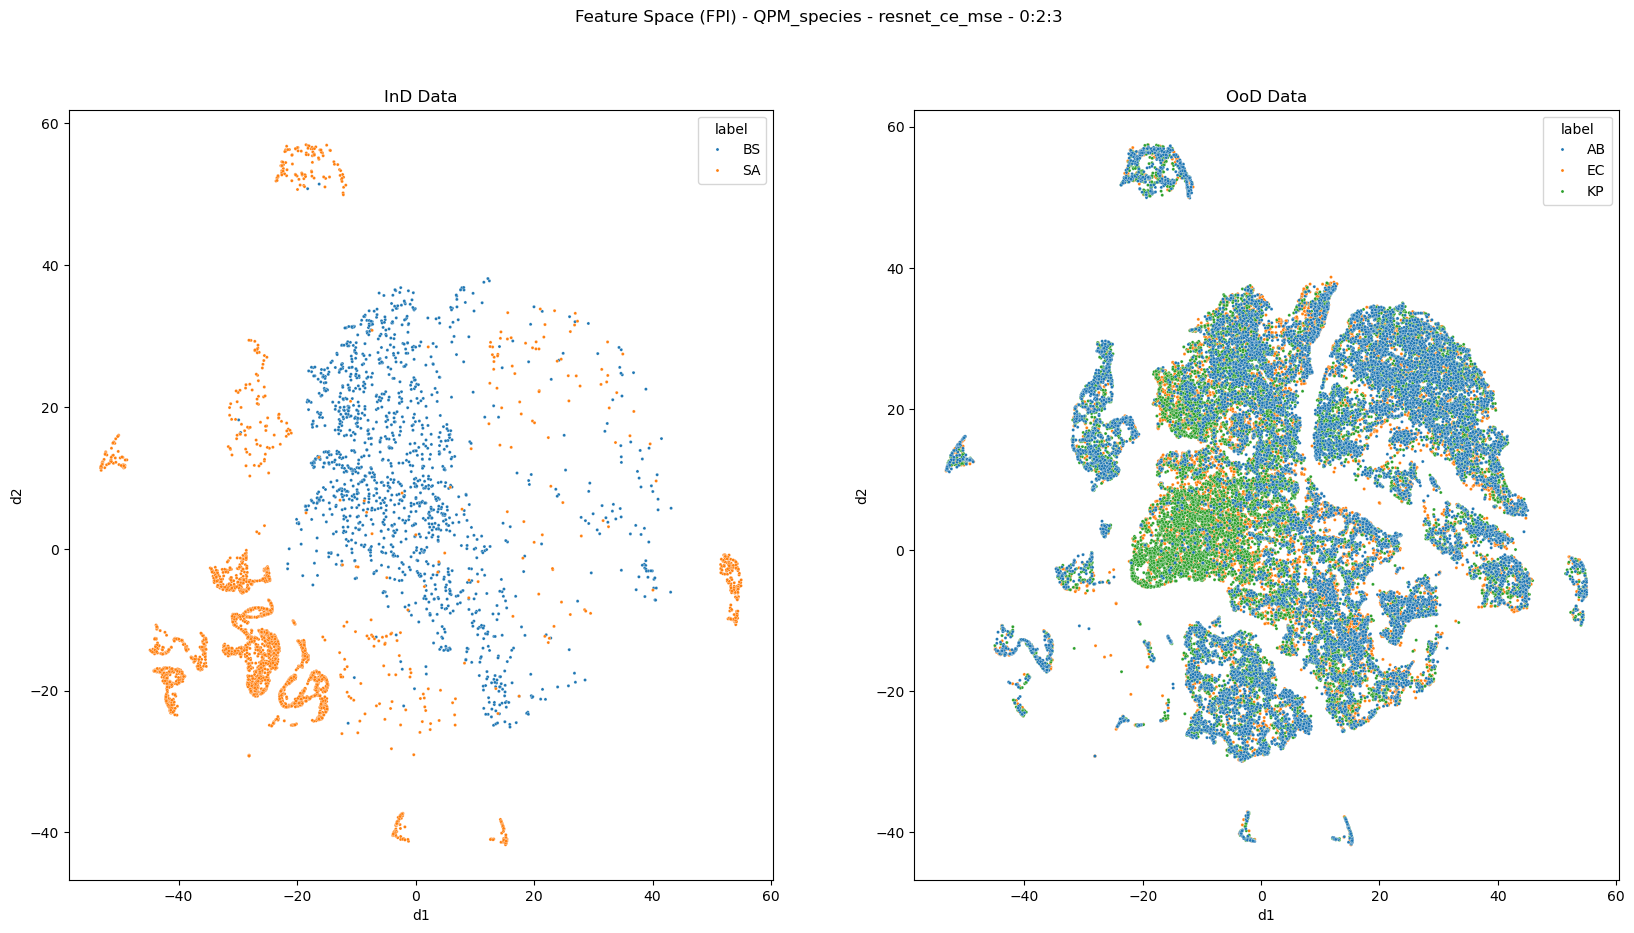

In [12]:
# plot feature space
df_emb_fpi2d = pd.DataFrame()
d1, d2 = ind_emb_fpi2d.T
df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb_fpi2d.T
    df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

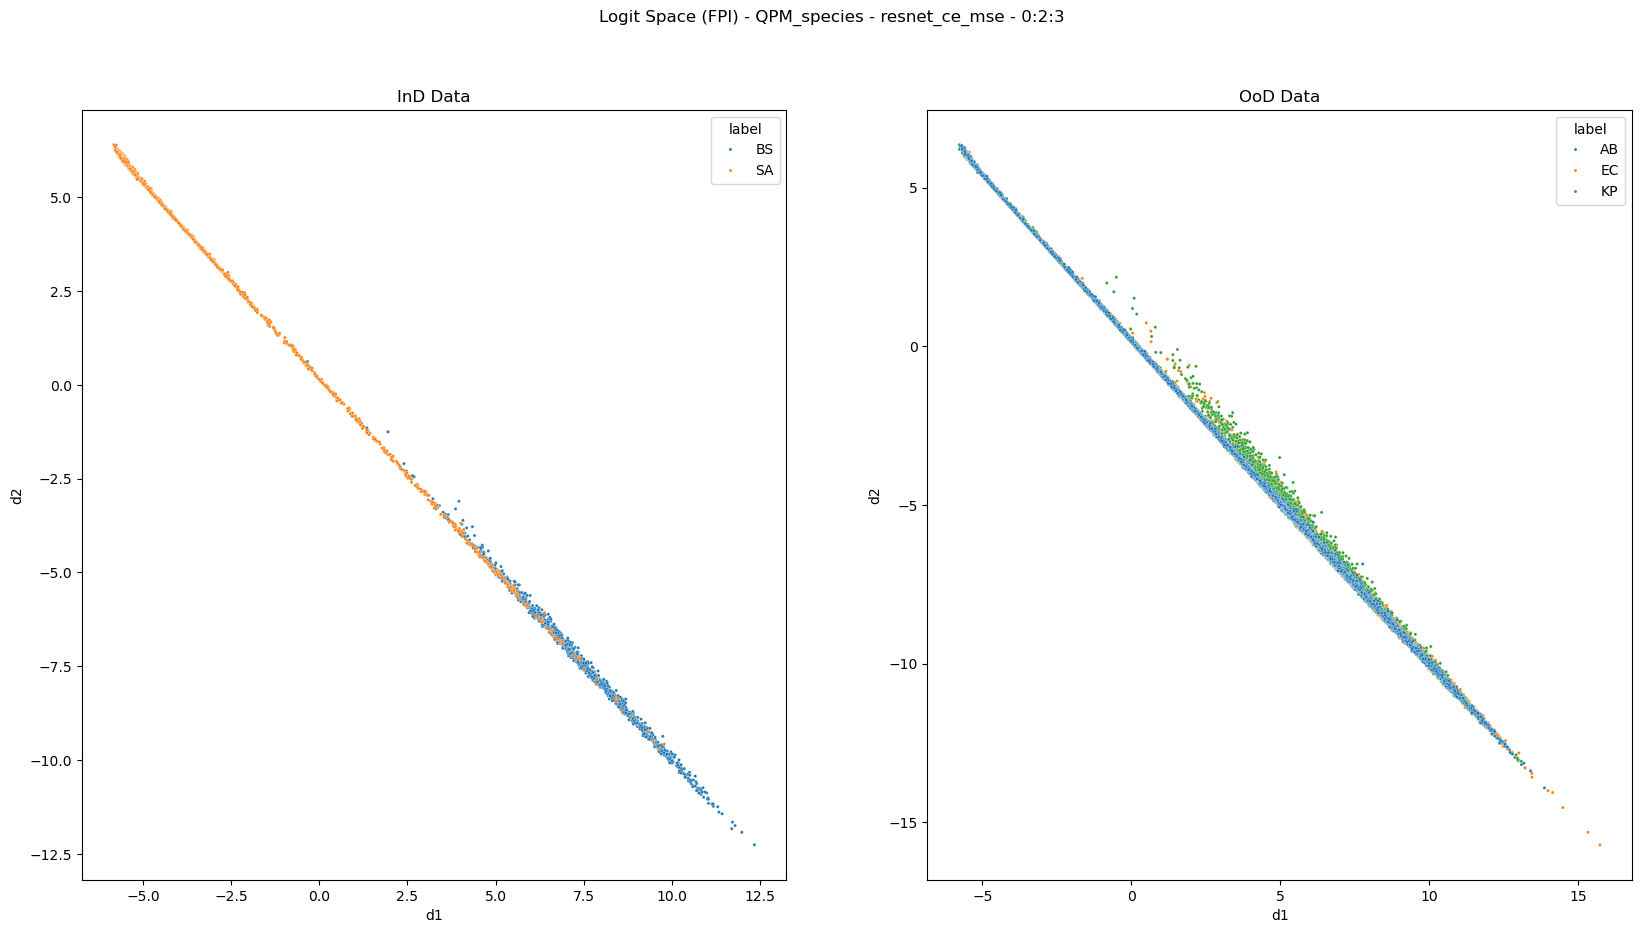

In [13]:
# plot logit space
df_lgt_fpi2d = pd.DataFrame()
d1, d2 = ind_lgt_fpi2d.T
df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt_fpi2d.T
    df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                                                   | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████▊                                                                                | 1/4 [00:02<00:06,  2.12s/it]

 50%|█████████████████████████████████████████████████████▌                                                     | 2/4 [00:04<00:04,  2.05s/it]

 75%|████████████████████████████████████████████████████████████████████████████████▎                          | 3/4 [00:06<00:02,  2.07s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.13s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.11s/it]

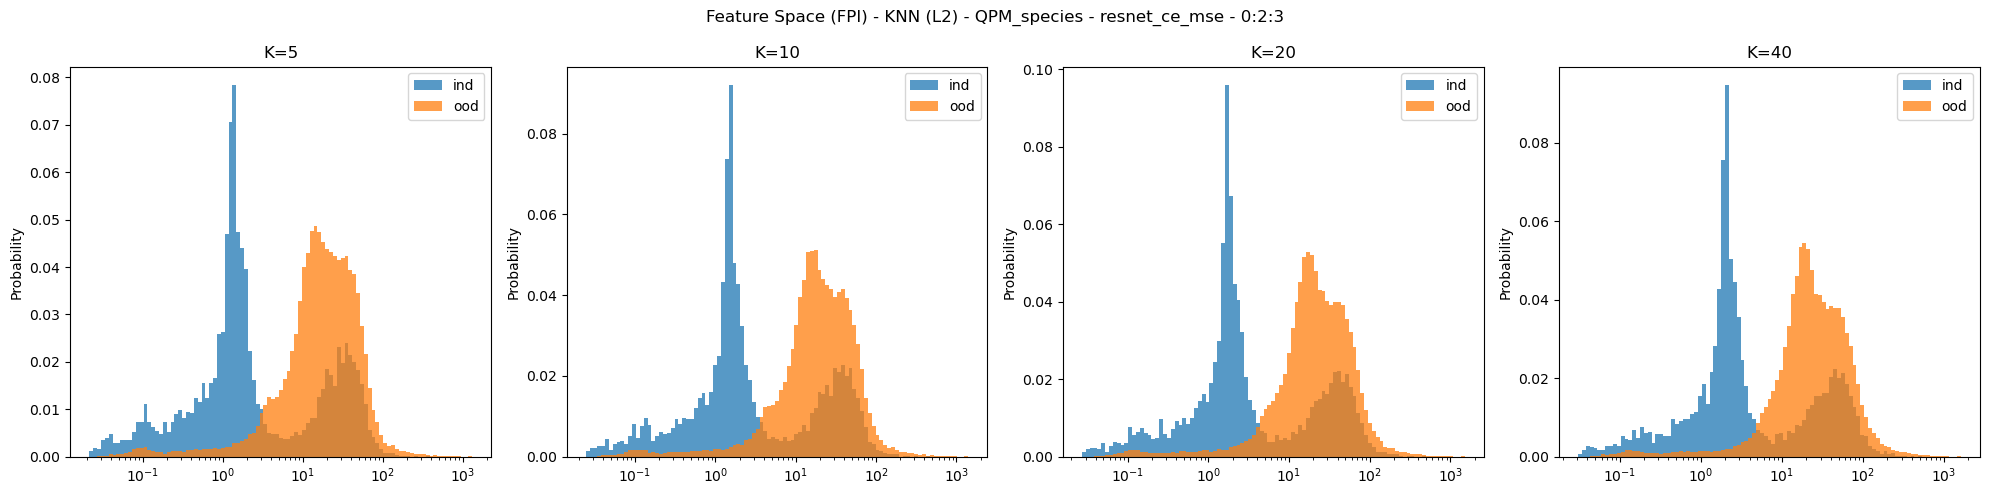

In [14]:
# plot knn to val data in feature space (L2)
index = faiss.IndexFlatL2(ind_emb_fpi.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space (FPI) - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                   | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████▊                                                                                | 1/4 [00:01<00:05,  1.91s/it]

 50%|█████████████████████████████████████████████████████▌                                                     | 2/4 [00:03<00:04,  2.01s/it]

 75%|████████████████████████████████████████████████████████████████████████████████▎                          | 3/4 [00:05<00:02,  2.00s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.04s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.02s/it]

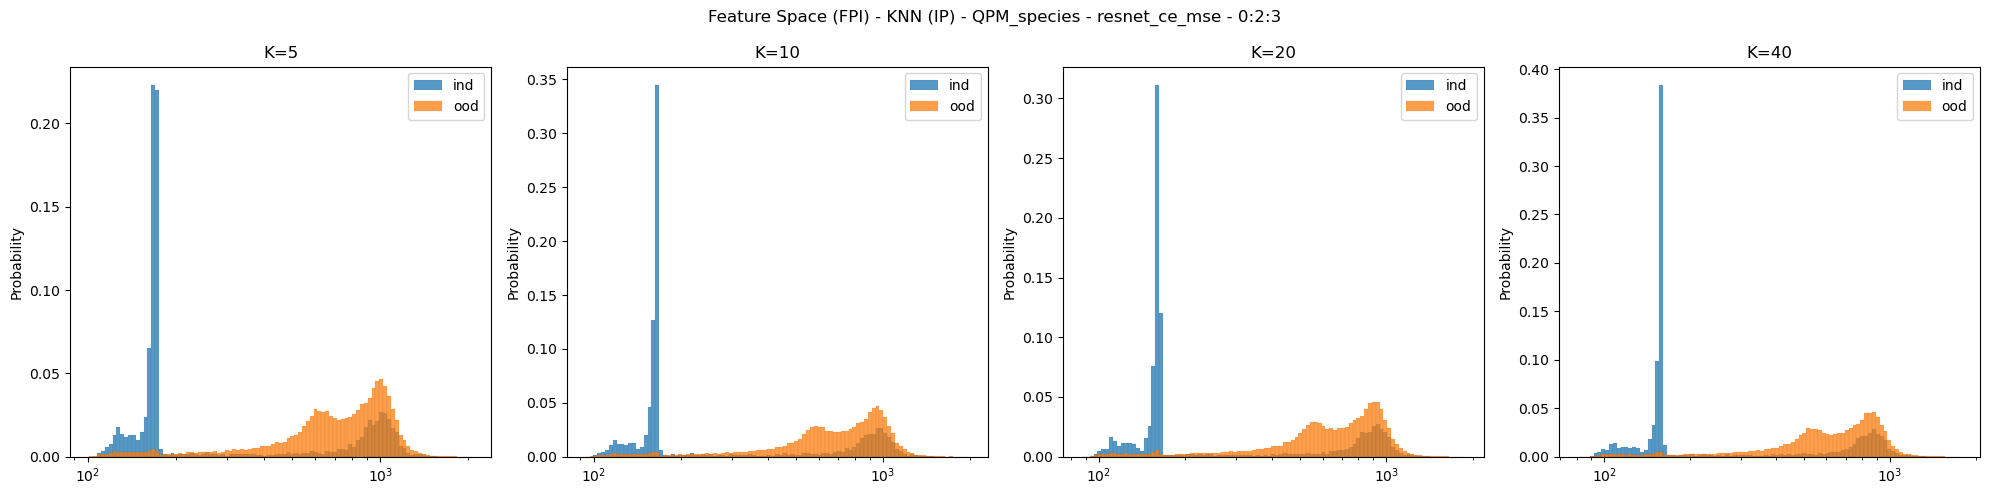

In [15]:
# check knn to val data in feature space (IP)
index = faiss.IndexFlatIP(ind_emb_fpi.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space (FPI) - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                   | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████▊                                                                                | 1/4 [00:01<00:05,  1.97s/it]

 50%|█████████████████████████████████████████████████████▌                                                     | 2/4 [00:03<00:03,  1.99s/it]

 75%|████████████████████████████████████████████████████████████████████████████████▎                          | 3/4 [00:06<00:02,  2.05s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.13s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.09s/it]

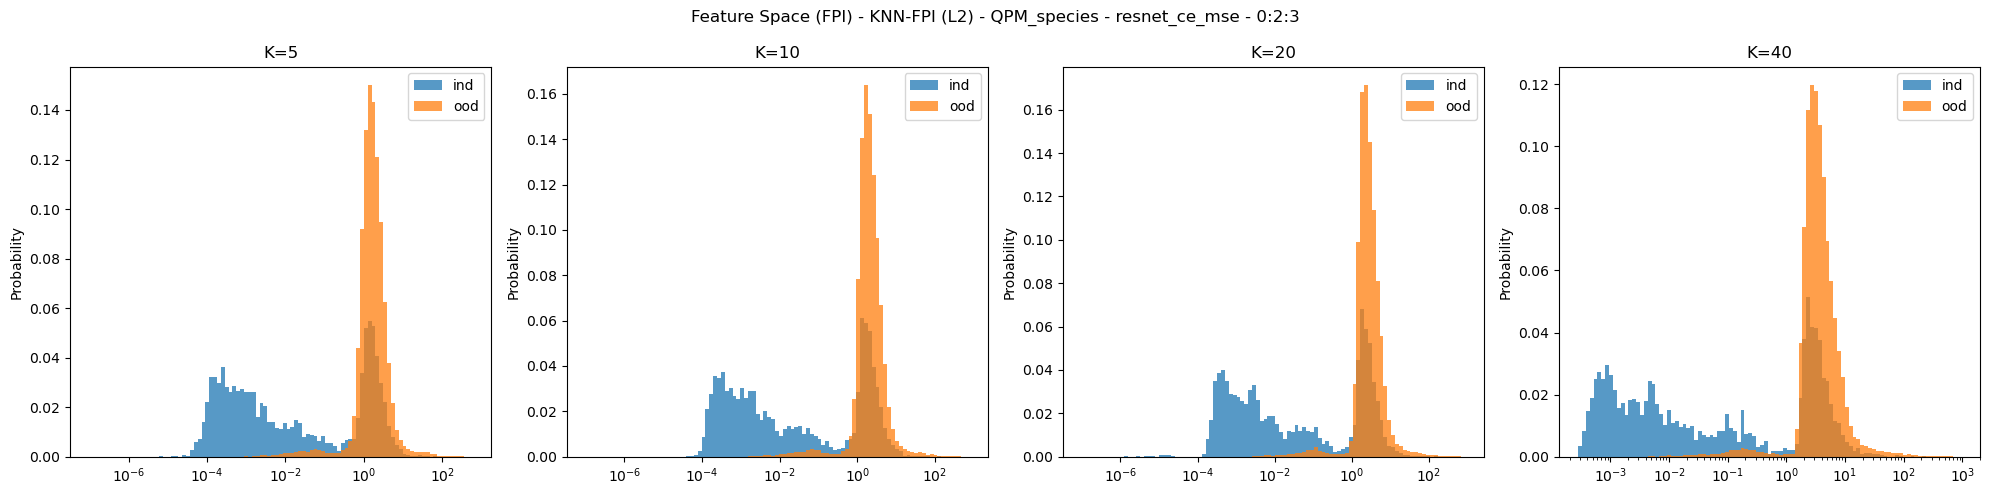

In [16]:
# check knn to val data FPI in feature space (L2)
index = faiss.IndexFlatL2(ind_emb_fpi.shape[-1])
index.add(val_emb_fpi)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space (FPI) - KNN-FPI (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                   | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████▊                                                                                | 1/4 [00:02<00:06,  2.11s/it]

 50%|█████████████████████████████████████████████████████▌                                                     | 2/4 [00:04<00:04,  2.01s/it]

 75%|████████████████████████████████████████████████████████████████████████████████▎                          | 3/4 [00:06<00:02,  2.02s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.07s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.06s/it]

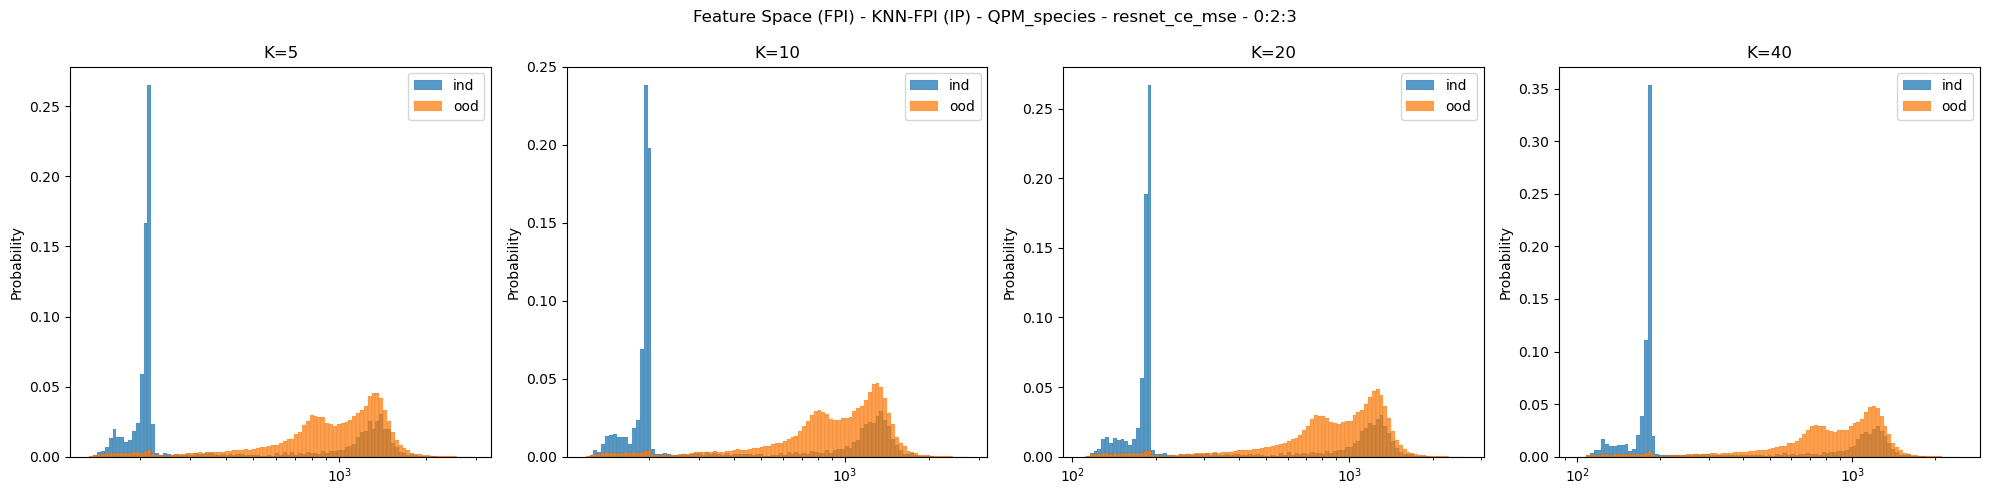

In [17]:
# check knn to val data FPI in feature space (IP)
index = faiss.IndexFlatIP(ind_emb_fpi.shape[-1])
index.add(val_emb_fpi)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space (FPI) - KNN-FPI (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                   | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████▊                                                                                | 1/4 [00:00<00:01,  2.58it/s]

 50%|█████████████████████████████████████████████████████▌                                                     | 2/4 [00:00<00:00,  2.49it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▎                          | 3/4 [00:01<00:00,  2.32it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]

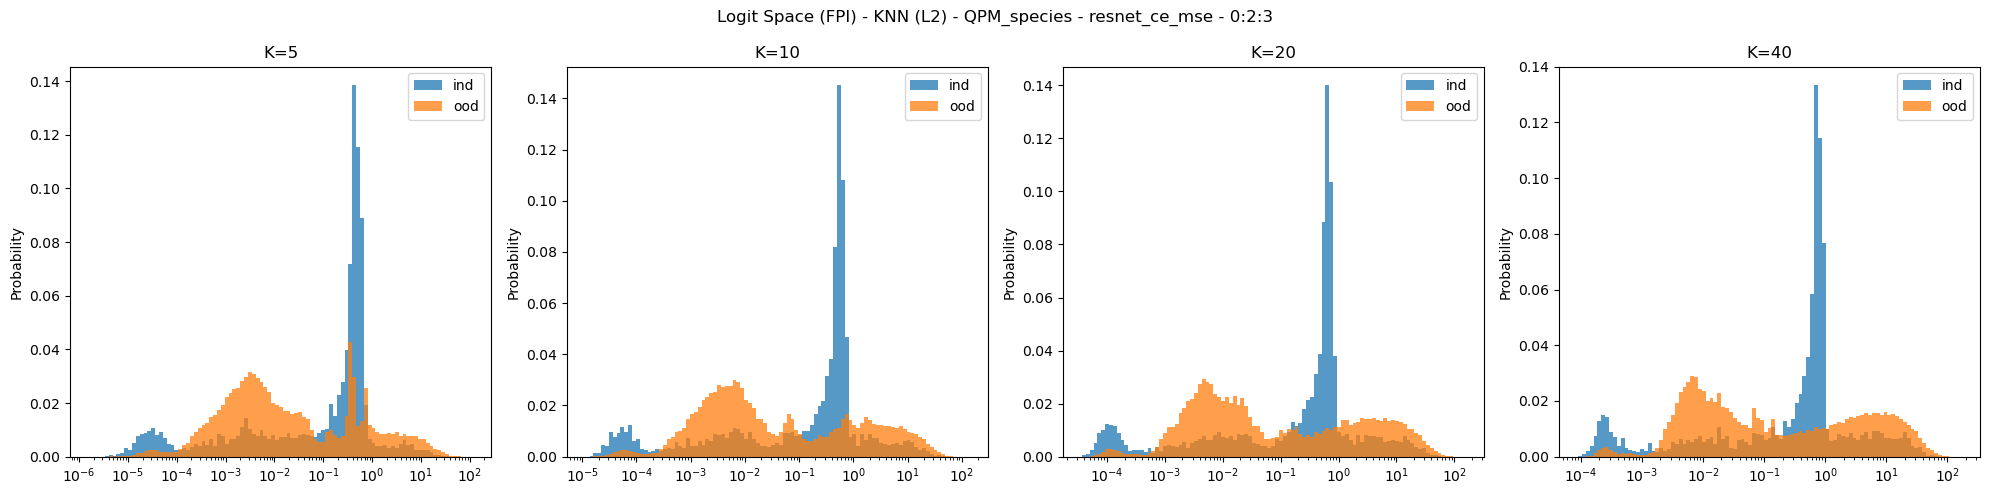

In [18]:
# check knn to val data in logit space (L2)
index = faiss.IndexFlatL2(ind_lgt_fpi.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space (FPI) - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                   | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████▊                                                                                | 1/4 [00:00<00:01,  2.91it/s]

 50%|█████████████████████████████████████████████████████▌                                                     | 2/4 [00:00<00:00,  2.89it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▎                          | 3/4 [00:01<00:00,  2.81it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.67it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.73it/s]

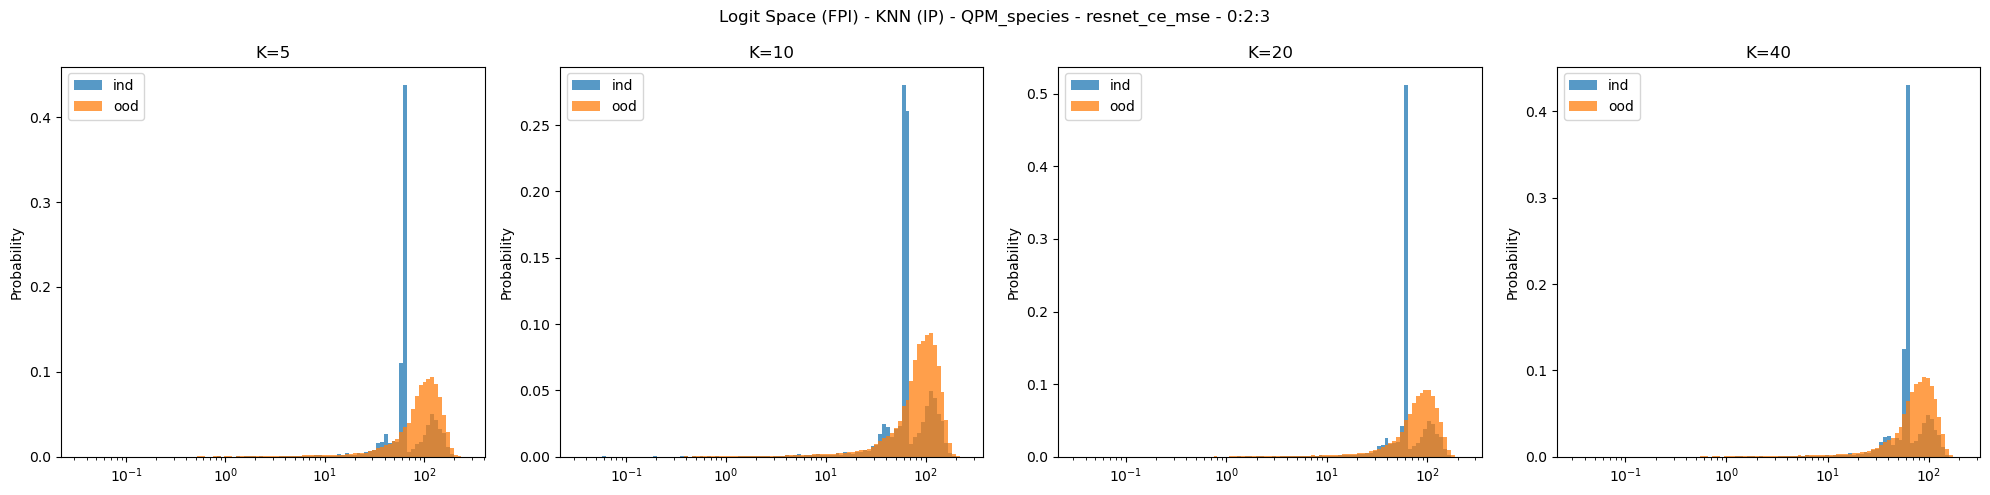

In [19]:
# check knn to val data in logit space (IP)
index = faiss.IndexFlatIP(ind_lgt_fpi.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space (FPI) - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                   | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████▊                                                                                | 1/4 [00:00<00:01,  2.54it/s]

 50%|█████████████████████████████████████████████████████▌                                                     | 2/4 [00:01<00:01,  1.81it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▎                          | 3/4 [00:01<00:00,  1.87it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.70it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.79it/s]

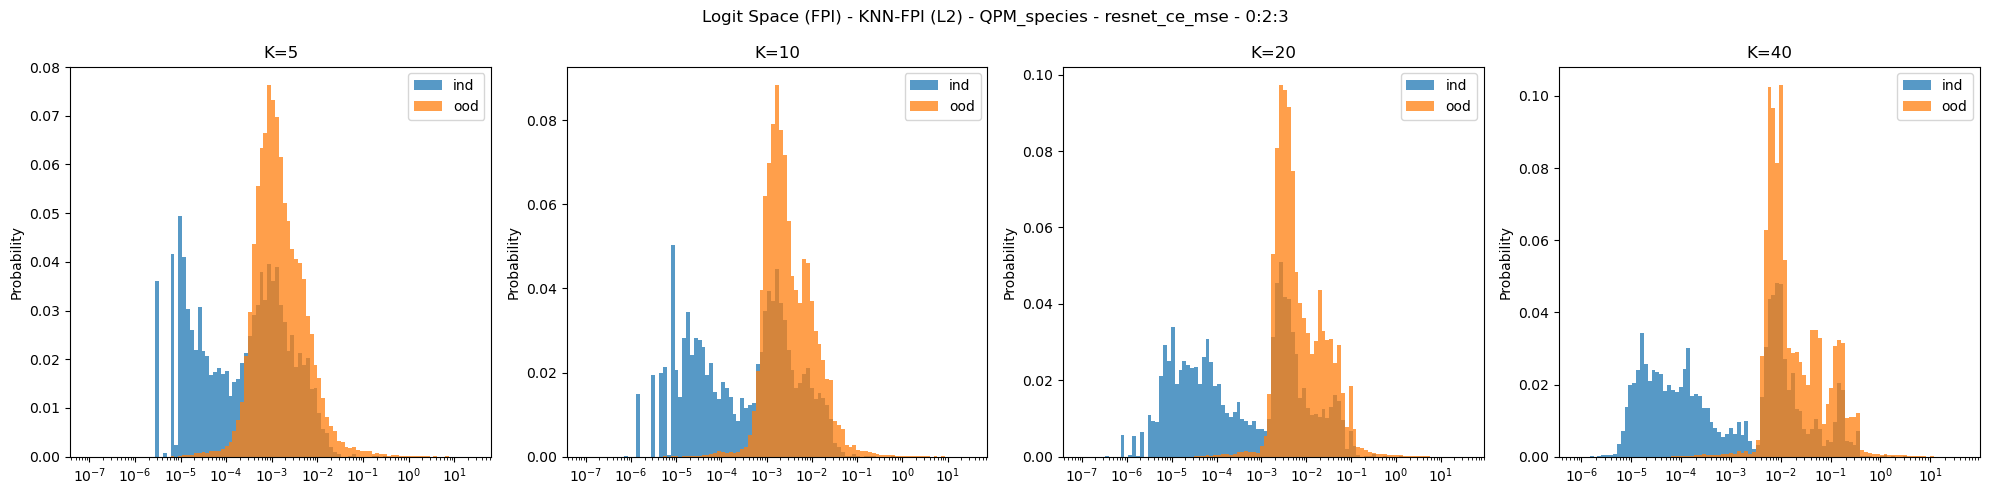

In [20]:
# check knn to val data FPI in logit space (L2)
index = faiss.IndexFlatL2(ind_lgt_fpi.shape[-1])
index.add(val_lgt_fpi)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space (FPI) - KNN-FPI (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                   | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████▊                                                                                | 1/4 [00:00<00:01,  2.88it/s]

 50%|█████████████████████████████████████████████████████▌                                                     | 2/4 [00:00<00:00,  2.89it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▎                          | 3/4 [00:01<00:00,  2.79it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.33it/s]

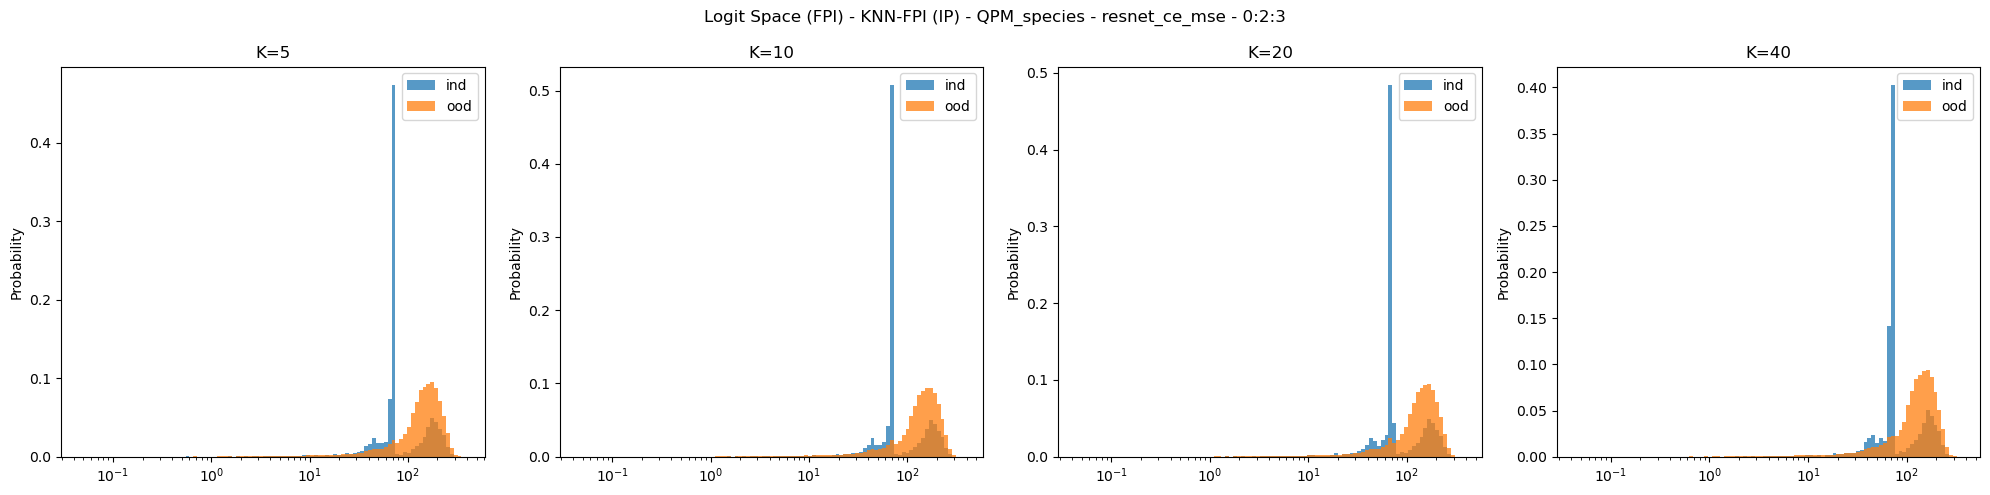

In [21]:
# check knn to val data FPI in logit space (IP)
index = faiss.IndexFlatIP(ind_lgt_fpi.shape[-1])
index.add(val_lgt_fpi)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space (FPI) - KNN-FPI (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

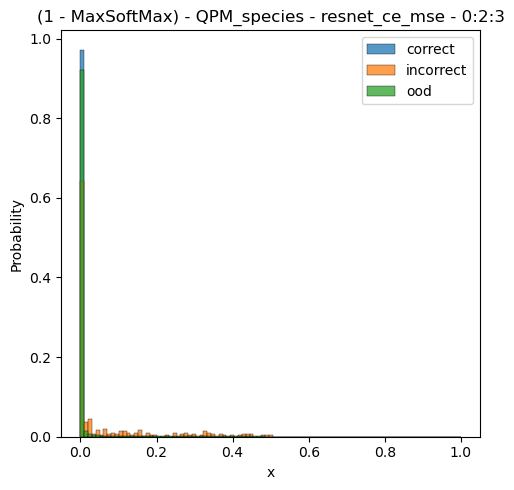

In [22]:
# plot (1 - maxsoftmax) distribution
ind_prob_fpi = np.exp(ind_lgt_fpi.astype(np.float64)) / np.exp(ind_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
ind_pred_fpi = ind_prob_fpi.argmax(-1)
ind_ucty_fpi = -ind_prob_fpi.max(-1) + 1.0

if ood_str:
    ood_prob_fpi = np.exp(ood_lgt_fpi.astype(np.float64)) / np.exp(ood_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred_fpi = ood_prob_fpi.argmax(-1)
    ood_ucty_fpi = -ood_prob_fpi.max(-1) + 1.0

df_t_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi == ind_tgt]}).copy()
df_f_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi != ind_tgt]}).copy()
df_fpi = pd.concat([df_t_fpi, df_f_fpi], ignore_index=True)
if ood_str:
    df_o_fpi = pd.DataFrame({"x": ood_ucty_fpi}).copy()
    df_fpi = pd.concat([df_fpi, df_o_fpi], ignore_index=True)
df_fpi_bins = np.linspace(0, 1, 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t_fpi, x="x", label="correct", stat="probability", bins=df_fpi_bins, ax=ax)
sns.histplot(df_f_fpi, x="x", label="incorrect", stat="probability", bins=df_fpi_bins, ax=ax)
if ood_str:
    sns.histplot(df_o_fpi, x="x", label="ood", stat="probability", bins=df_fpi_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

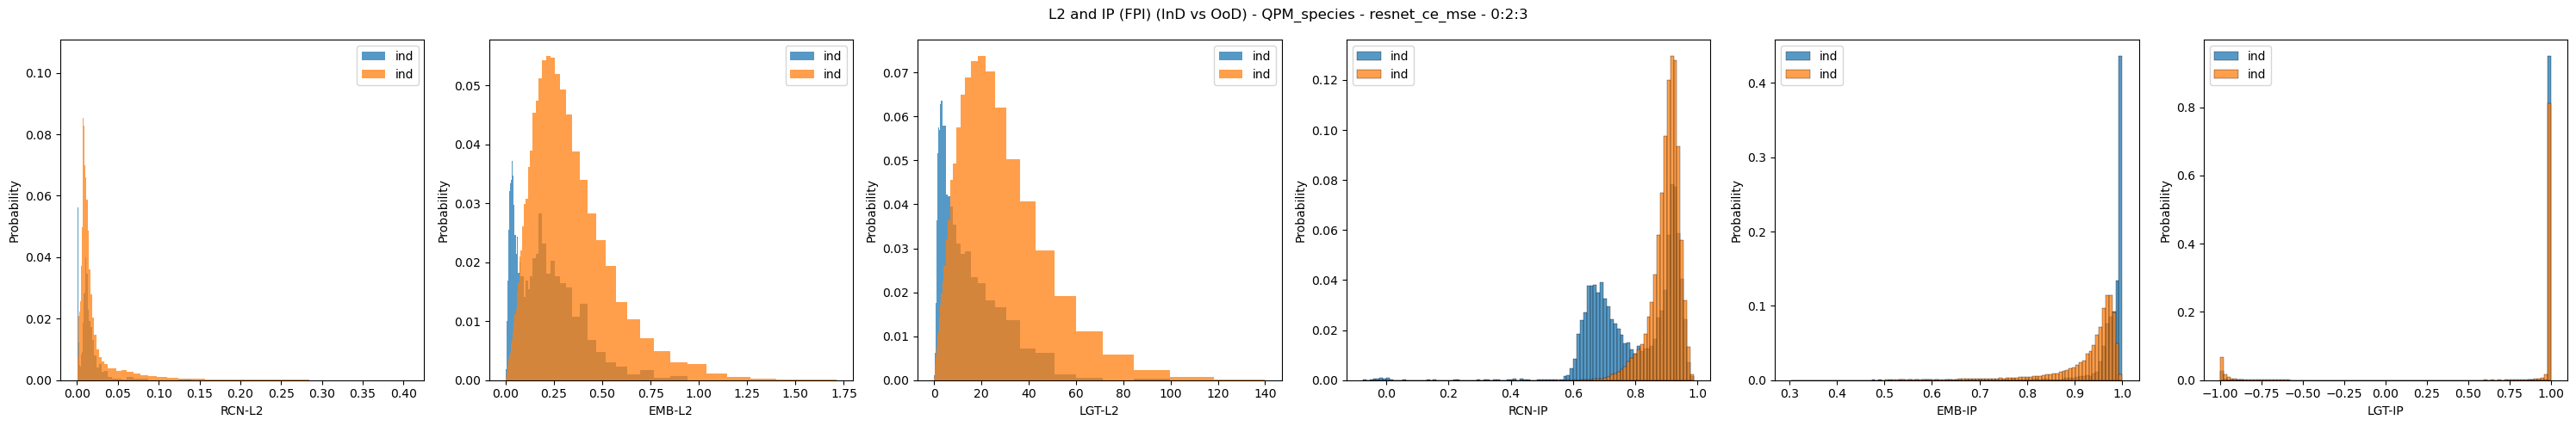

In [23]:
# plot fpi-reconstruction-based ood metrics
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=6, figsize=(30, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
# data
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
_ind_emb = ind_emb.reshape(si)
_ind_lgt = ind_lgt.reshape(si)
_ind_rcn_fpi = ind_rcn_fpi.reshape(si)
_ind_emb_fpi = ind_emb_fpi.reshape(si)
_ind_lgt_fpi = ind_lgt_fpi.reshape(si)
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
_ind_emb_unit = _ind_emb / (np.linalg.norm(_ind_emb, axis=-1, keepdims=True) + 1e-7)
_ind_lgt_unit = _ind_lgt / (np.linalg.norm(_ind_lgt, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_fpi_unit = _ind_rcn_fpi / (np.linalg.norm(_ind_rcn_fpi, axis=-1, keepdims=True) + 1e-7)
_ind_emb_fpi_unit = _ind_emb_fpi / (np.linalg.norm(_ind_emb_fpi, axis=-1, keepdims=True) + 1e-7)
_ind_lgt_fpi_unit = _ind_lgt_fpi / (np.linalg.norm(_ind_lgt_fpi, axis=-1, keepdims=True) + 1e-7)
# mse
ind_rcn_l2_fpi = ((_ind_inp - _ind_rcn_fpi) ** 2).mean(-1)
ind_emb_l2_fpi = ((_ind_emb - _ind_emb_fpi) ** 2).mean(-1)
ind_lgt_l2_fpi = ((_ind_lgt - _ind_lgt_fpi) ** 2).mean(-1)
# ip
ind_rcn_ip_fpi = (_ind_inp_unit * _ind_rcn_fpi_unit).sum(-1)
ind_emb_ip_fpi = (_ind_emb_unit * _ind_emb_fpi_unit).sum(-1)
ind_lgt_ip_fpi = (_ind_lgt_unit * _ind_lgt_fpi_unit).sum(-1)
# store
_df = pd.DataFrame(dict(
    target=ind_tgt,
    rcn_l2=ind_rcn_l2_fpi,
    emb_l2=ind_emb_l2_fpi,
    lgt_l2=ind_lgt_l2_fpi,
    rcn_ip=ind_rcn_ip_fpi,
    emb_ip=ind_emb_ip_fpi,
    lgt_ip=ind_lgt_ip_fpi,
    source="ind",
))
df_rstat = pd.concat([df_rstat, _df], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    # data
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    _ood_emb = ood_emb.reshape(so)
    _ood_lgt = ood_lgt.reshape(so)
    _ood_rcn_fpi = ood_rcn_fpi.reshape(so)
    _ood_emb_fpi = ood_emb_fpi.reshape(so)
    _ood_lgt_fpi = ood_lgt_fpi.reshape(so)
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    _ood_emb_unit = _ood_emb / (np.linalg.norm(_ood_emb, axis=-1, keepdims=True) + 1e-7)
    _ood_lgt_unit = _ood_lgt / (np.linalg.norm(_ood_lgt, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_fpi_unit = _ood_rcn_fpi / (np.linalg.norm(_ood_rcn_fpi, axis=-1, keepdims=True) + 1e-7)
    _ood_emb_fpi_unit = _ood_emb_fpi / (np.linalg.norm(_ood_emb_fpi, axis=-1, keepdims=True) + 1e-7)
    _ood_lgt_fpi_unit = _ood_lgt_fpi / (np.linalg.norm(_ood_lgt_fpi, axis=-1, keepdims=True) + 1e-7)
    # mse
    ood_rcn_l2_fpi = ((_ood_inp - _ood_rcn_fpi) ** 2).mean(-1)
    ood_emb_l2_fpi = ((_ood_emb - _ood_emb_fpi) ** 2).mean(-1)
    ood_lgt_l2_fpi = ((_ood_lgt - _ood_lgt_fpi) ** 2).mean(-1)
    # ip
    ood_rcn_ip_fpi = (_ood_inp_unit * _ood_rcn_fpi_unit).sum(-1)
    ood_emb_ip_fpi = (_ood_emb_unit * _ood_emb_fpi_unit).sum(-1)
    ood_lgt_ip_fpi = (_ood_lgt_unit * _ood_lgt_fpi_unit).sum(-1)
    # store
    _df = pd.DataFrame(dict(
        target=ood_tgt,
        rcn_l2=ood_rcn_l2_fpi,
        emb_l2=ood_emb_l2_fpi,
        lgt_l2=ood_lgt_l2_fpi,
        rcn_ip=ood_rcn_ip_fpi,
        emb_ip=ood_emb_ip_fpi,
        lgt_ip=ood_lgt_ip_fpi,
        source="ood",
    ))
    df_rstat = pd.concat([df_rstat, _df], ignore_index=True)
    
bins_rcn_l2 = np.logspace(np.log10(df_rstat['rcn_l2'].min() + 1e-7), np.log10(df_rstat['rcn_l2'].max()), 100)
bins_emb_l2 = np.logspace(np.log10(df_rstat['emb_l2'].min() + 1e-7), np.log10(df_rstat['emb_l2'].max()), 100)
bins_lgt_l2 = np.logspace(np.log10(df_rstat['lgt_l2'].min() + 1e-7), np.log10(df_rstat['lgt_l2'].max()), 100)
bins_rcn_ip = np.linspace(df_rstat['rcn_ip'].min(), df_rstat['rcn_ip'].max(), 100)
bins_emb_ip = np.linspace(df_rstat['emb_ip'].min(), df_rstat['emb_ip'].max(), 100)
bins_lgt_ip = np.linspace(df_rstat['lgt_ip'].min(), df_rstat['lgt_ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="rcn_l2", label="ind", stat="probability", bins=bins_rcn_l2, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="emb_l2", label="ind", stat="probability", bins=bins_emb_l2, ax=ax2)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="lgt_l2", label="ind", stat="probability", bins=bins_lgt_l2, ax=ax3)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="rcn_ip", label="ind", stat="probability", bins=bins_rcn_ip, ax=ax4)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="emb_ip", label="ind", stat="probability", bins=bins_emb_ip, ax=ax5)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="lgt_ip", label="ind", stat="probability", bins=bins_lgt_ip, ax=ax6)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="rcn_l2", label="ind", stat="probability", bins=bins_rcn_l2, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="emb_l2", label="ind", stat="probability", bins=bins_emb_l2, ax=ax2)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="lgt_l2", label="ind", stat="probability", bins=bins_lgt_l2, ax=ax3)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="rcn_ip", label="ind", stat="probability", bins=bins_rcn_ip, ax=ax4)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="emb_ip", label="ind", stat="probability", bins=bins_emb_ip, ax=ax5)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="lgt_ip", label="ind", stat="probability", bins=bins_lgt_ip, ax=ax6)

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()
ax6.legend()
ax1.set_xlabel("RCN-L2")
ax2.set_xlabel("EMB-L2")
ax3.set_xlabel("LGT-L2")
ax4.set_xlabel("RCN-IP")
ax5.set_xlabel("EMB-IP")
ax6.set_xlabel("LGT-IP")
plt.suptitle(f"L2 and IP (FPI) (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()